# Replicate the CERES model

## The CERES model

The following is the CERES model as desicrbed in ["Computational correction of copy number effect improves specificity of CRISPR–Cas9 essentiality screens in cancer cells"](https://www.nature.com/articles/ng.3984#Sec24) (Meyeres *et al*, 2017).


$
\quad D_{ij} = q_i \lgroup \sum_{k \in G_i} (h_k + g_{kj}) + \mathcal{f} (\sum_{l \in L_i} C_{lj}) \rgroup + o_i + \epsilon
$

where:

- $D_{ij}$: sgRNA $i$ depletion in cell line $j$
- $q_i$: "guide activity score... to mitigate the influence of low-quality reagents" (restricted $[0,1]$)
- $G_i$: the genes targeted by sgRNA $i$
- $h_k$: "shared" (non-cell-line-specific) effect of gene $k$
- $g_{kj}$: cell-line-specific effect in cell line $j$ and gene $k$
- $\mathcal{f}_j$: piecewise linear spine to model copy number effect
- $L_i$: target loci of sgRNA $i$
- $C_{lj}$: copy number of target locus $l$ in cell line $j$
- $o_i$: sgRNA-sepcific effect to account for noise in the measurement of sgRNA abundance in the reference pool
- $\epsilon$: normal error

### Notebook goal

Here I will build three models: (1) without a CN covariate, (2) with a standard linear covariate for copy number, and (3) with a spline function for the CNA covariate.
In this notebook, the models will be run with a subsample of the data, but they will eventually be turned into Python scripts to run on the full data set.

### Set-up

In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
from theano import tensor as tt

notebook_tic = time()
warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

### Data preparation

In [2]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)
data.head(n=7)

sgrna                     replicate_id       lfc  \
0  AAGAGGCCGGTCAAATTCAG  42-mg-ba-311cas9_repa_p6_batch3 -0.405499   
1  AATCAACCCACAGCTGCACA  42-mg-ba-311cas9_repa_p6_batch3 -0.133541   
2  AATTACTACTTGCTTCCTGT  42-mg-ba-311cas9_repa_p6_batch3 -0.491495   
3  ACCTGTATGACGAAACCGTG  42-mg-ba-311cas9_repa_p6_batch3 -0.015850   
4  ACTCTGTTCCTTCATCTCCG  42-mg-ba-311cas9_repa_p6_batch3 -0.530277   
5  ACTGCTGCGGGAATTCCAAG  42-mg-ba-311cas9_repa_p6_batch3  0.778827   
6  AGACACTTATACTATGAAAG  42-mg-ba-311cas9_repa_p6_batch3  0.035950   

   pdna_batch  passes_qc   depmap_id primary_or_metastasis  \
0           3       True  ACH-000323               Primary   
1           3       True  ACH-000323               Primary   
2           3       True  ACH-000323               Primary   
3           3       True  ACH-000323               Primary   
4           3       True  ACH-000323               Primary   
5           3       True  ACH-000323               Primary   
6           3       True  ACH-000323               Primary   

                  lineage lineage_subtype kras_mutation  ... log2_gene_cn_p1  \
0  central_nervous_system          glioma            WT  ...        0.845287   
1  central_nervous_system          glioma            WT  ...        0.827398   
2  central_nervous_system          glioma            WT  ...        0.879280   
3  central_nervous_system          glioma            WT  ...        0.818549   
4  central_nervous_system          glioma            WT  ...        0.990378   
5  central_nervous_system          glioma            WT  ...        0.818549   
6  central_nervous_system          glioma            WT  ...        0.872323   

    gene_cn n_muts  any_deleterious               variant_classification  \
0  1.328646      0            False                                  NaN   
1  1.287359      2            False  missense_mutation;missense_mutation   
2  1.409165      0            False                                  NaN   
3  1.267208      0            False                                  NaN   
4  1.692253      0            False                                  NaN   
5  1.267208      0            False                                  NaN   
6  1.392463      0            False                                  NaN   

   is_deleterious  is_tcga_hotspot  is_cosmic_hotspot  \
0             NaN              NaN                NaN   
1     FALSE;FALSE        TRUE;TRUE          TRUE;TRUE   
2             NaN              NaN                NaN   
3             NaN              NaN                NaN   
4             NaN              NaN                NaN   
5             NaN              NaN                NaN   
6             NaN              NaN                NaN   

   mutated_at_guide_location  rna_expr  
0                      False  1.263034  
1                      False  5.220330  
2                      False  3.008989  
3                      False  4.083213  
4                      False  5.822730  
5                      False  4.083213  
6                      False  3.701549  

[7 rows x 27 columns]

In [3]:
np.random.seed(RANDOM_SEED)
SAMPLED_GENES = data["hugo_symbol"].unique()
SAMPLED_CELL_LINES = np.random.choice(data["depmap_id"].unique(), 100)
data = data[data["hugo_symbol"].isin(SAMPLED_GENES)]
data = data[data["depmap_id"].isin(SAMPLED_CELL_LINES)]

In [4]:
print(f"testing with {data.shape[0]} data points")

testing with 19982 data points


In [5]:
def make_cat(df, col, ordered=True):
    """Make a column of a data frame into categorical."""
    df[col] = pd.Categorical(df[col], categories=df[col].unique(), ordered=ordered)
    return df


cat_cols = [
    "sgrna",
    "replicate_id",
    "pdna_batch",
    "depmap_id",
    "lineage",
    "kras_mutation",
    "hugo_symbol",
    "chromosome",
]

for col in cat_cols:
    data = make_cat(data, col)

In [6]:
def count_unique(df, col):
    """Count the number of unique values in a column."""
    return len(df[col].unique())


def get_indices(df, col):
    """Get a list of the indices for a column."""
    return df[col].cat.codes.to_numpy()


num_sgrnas = count_unique(data, "sgrna")
num_genes = count_unique(data, "hugo_symbol")
num_cell_lines = count_unique(data, "depmap_id")

sgrna_idx = get_indices(data, "sgrna")
gene_idx = get_indices(data, "hugo_symbol")
cell_line_idx = get_indices(data, "depmap_id")

In [7]:
data["gene_cn_z"] = data["gene_cn"].apply(lambda x: np.min((x, 10)))
data["gene_cn_z"] = data.groupby("hugo_symbol")["gene_cn_z"].apply(
    lambda x: (x - np.mean(x)) / np.std(x)
)

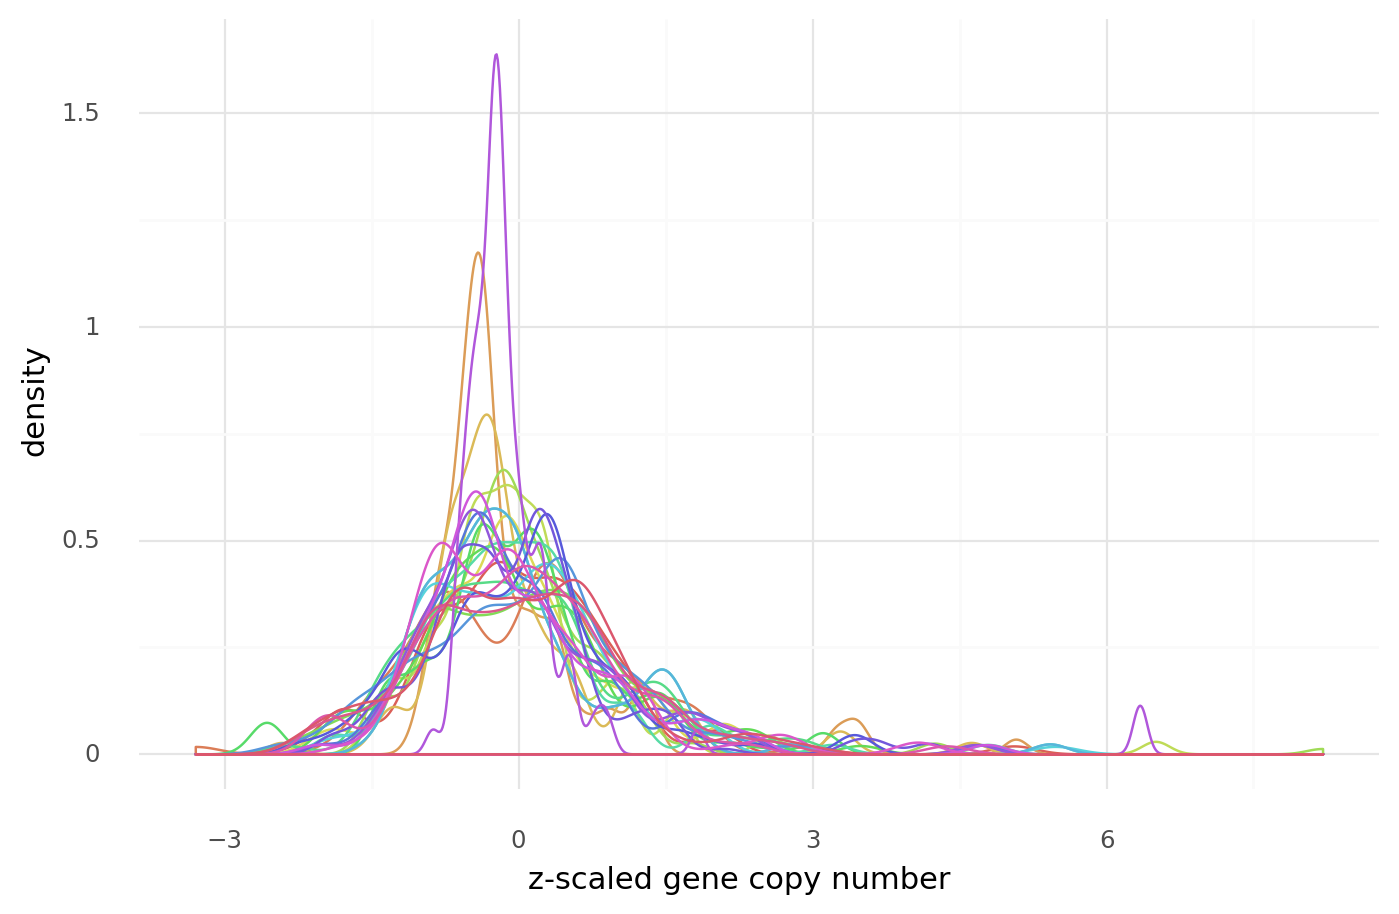

<ggplot: (8768007891231)>

In [8]:
(
    gg.ggplot(data, gg.aes(x="gene_cn_z"))
    + gg.geom_density(gg.aes(color="hugo_symbol"), size=0.5)
    + gg.scale_color_discrete(guide=False)
    + gg.theme(figure_size=(8, 5))
    + gg.labs(x="z-scaled gene copy number", y="density")
)

## Modeling

### Model 1.

Below is the model that will be fit with PyMC3 as the mimic of CERES without any covariate for the gene CN.

$
\quad D_{ij} \sim \mathcal{N}(\mu_{ij}, \epsilon) \\
\quad \mu_{ij} = q_i \lgroup h_k + g_{kj} \rgroup + o_i \\
\qquad q_i \sim \text{Beta}(2, 2) \\
\qquad h_k \sim \mathcal{N}(0, 1) \\
\qquad g_{kj} \sim \mathcal{N}(0, 1) \\
\qquad o_i \sim \mathcal{N}(0, 1) \\
\quad \epsilon \sim \text{Exp}(1)
$

In [9]:
with pm.Model() as ceres_m1:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 2, shape=(num_genes, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = pm.Deterministic(
        "mu",
        q_i[sgrna_idx] * (h_k[gene_idx] + g_kj[gene_idx, cell_line_idx])
        + o_i[sgrna_idx],
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=data.lfc)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


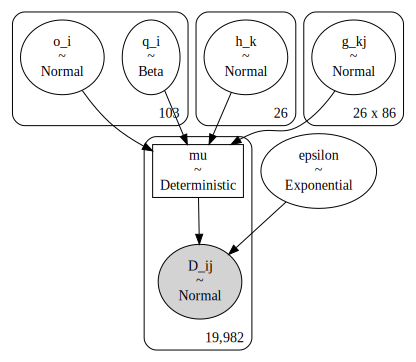

In [10]:
pm.model_to_graphviz(ceres_m1)

In [11]:
%%time

ceres_m1_cachedir = pymc3_cache_dir / "ceres_m1"

ceres_m1_samples = pmhelp.pymc3_sampling_procedure(
    model=ceres_m1,
    num_mcmc=3000,
    tune=1500,
    chains=3,
    cores=4,
    prior_check_samples=1000,
    ppc_samples=2000,
    random_seed=RANDOM_SEED,
    cache_dir=ceres_m1_cachedir,
    force=False,
)

Loading cached trace and posterior sample...


/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


CPU times: user 8.02 s, sys: 1.96 s, total: 9.99 s
Wall time: 20.1 s


In [12]:
az_ceres_m1 = az.from_pymc3(
    trace=ceres_m1_samples["trace"],
    model=ceres_m1,
    prior=ceres_m1_samples["prior_predictive"],
    posterior_predictive=ceres_m1_samples["posterior_predictive"],
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
arviz.data.io_pymc3 - WARNING - posterior predictive variable D_ij's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


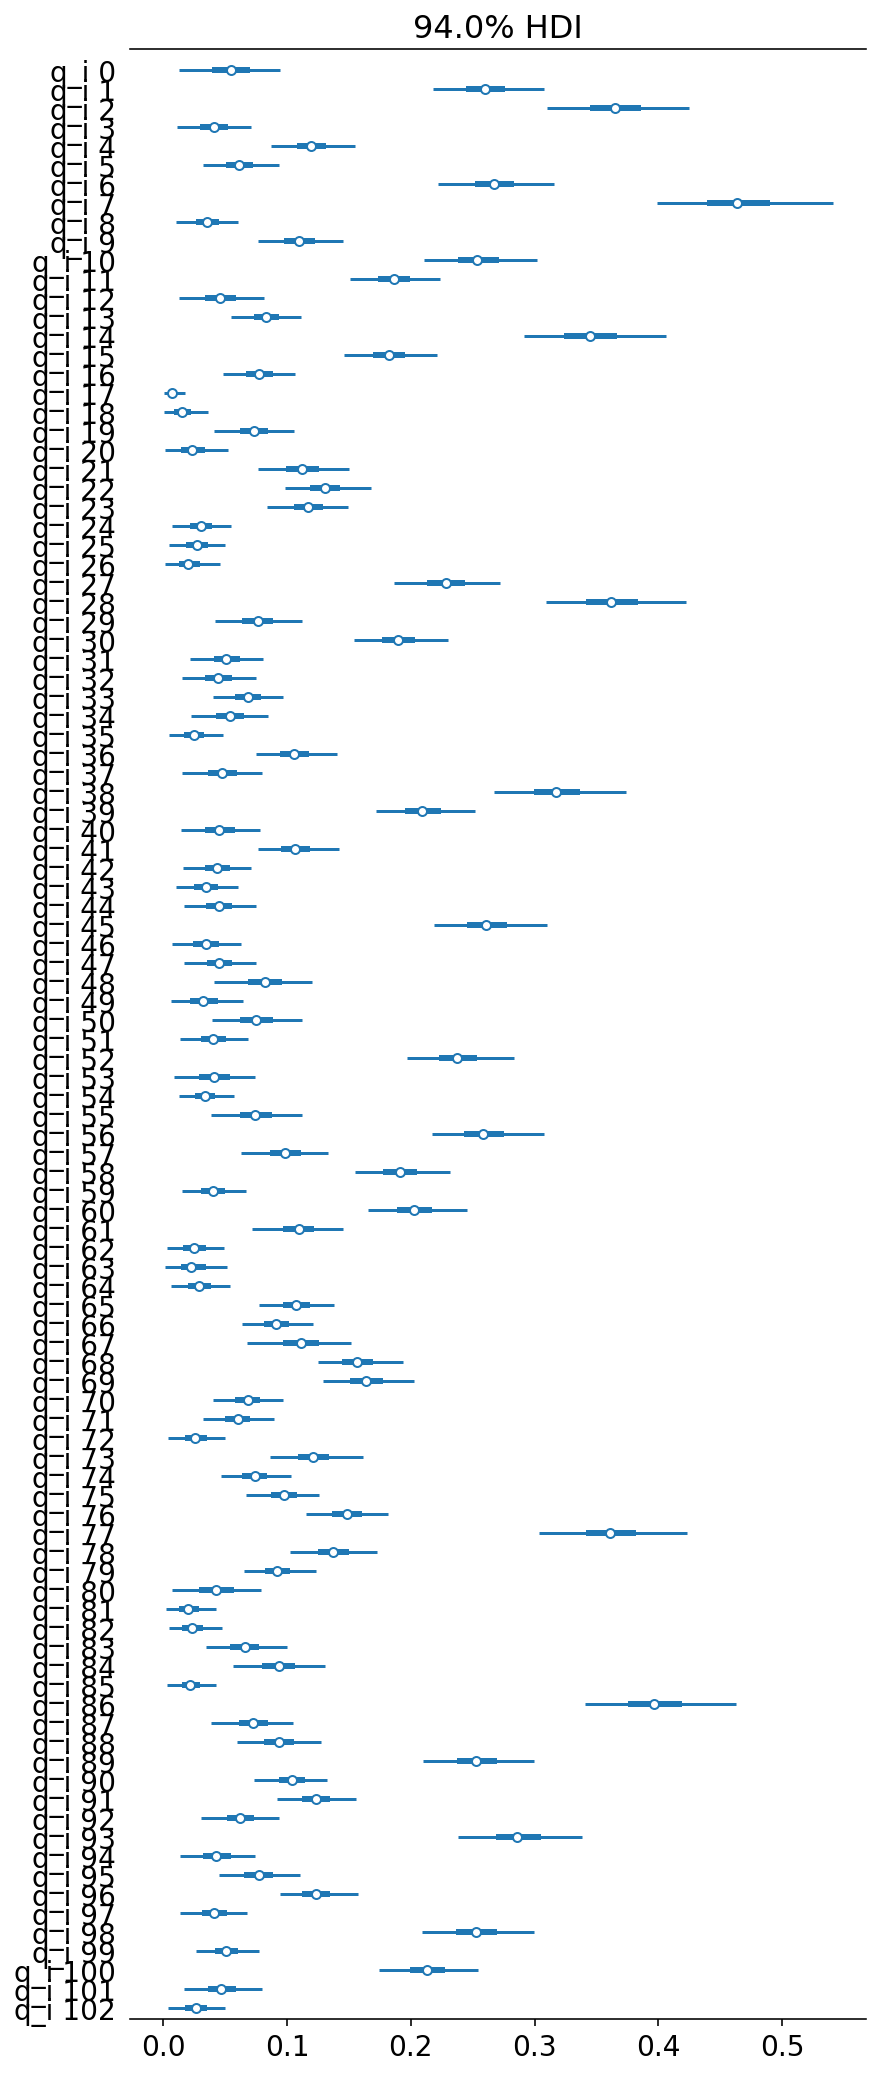

In [13]:
az.plot_forest(az_ceres_m1, var_names="q_i", combined=True)
plt.show()

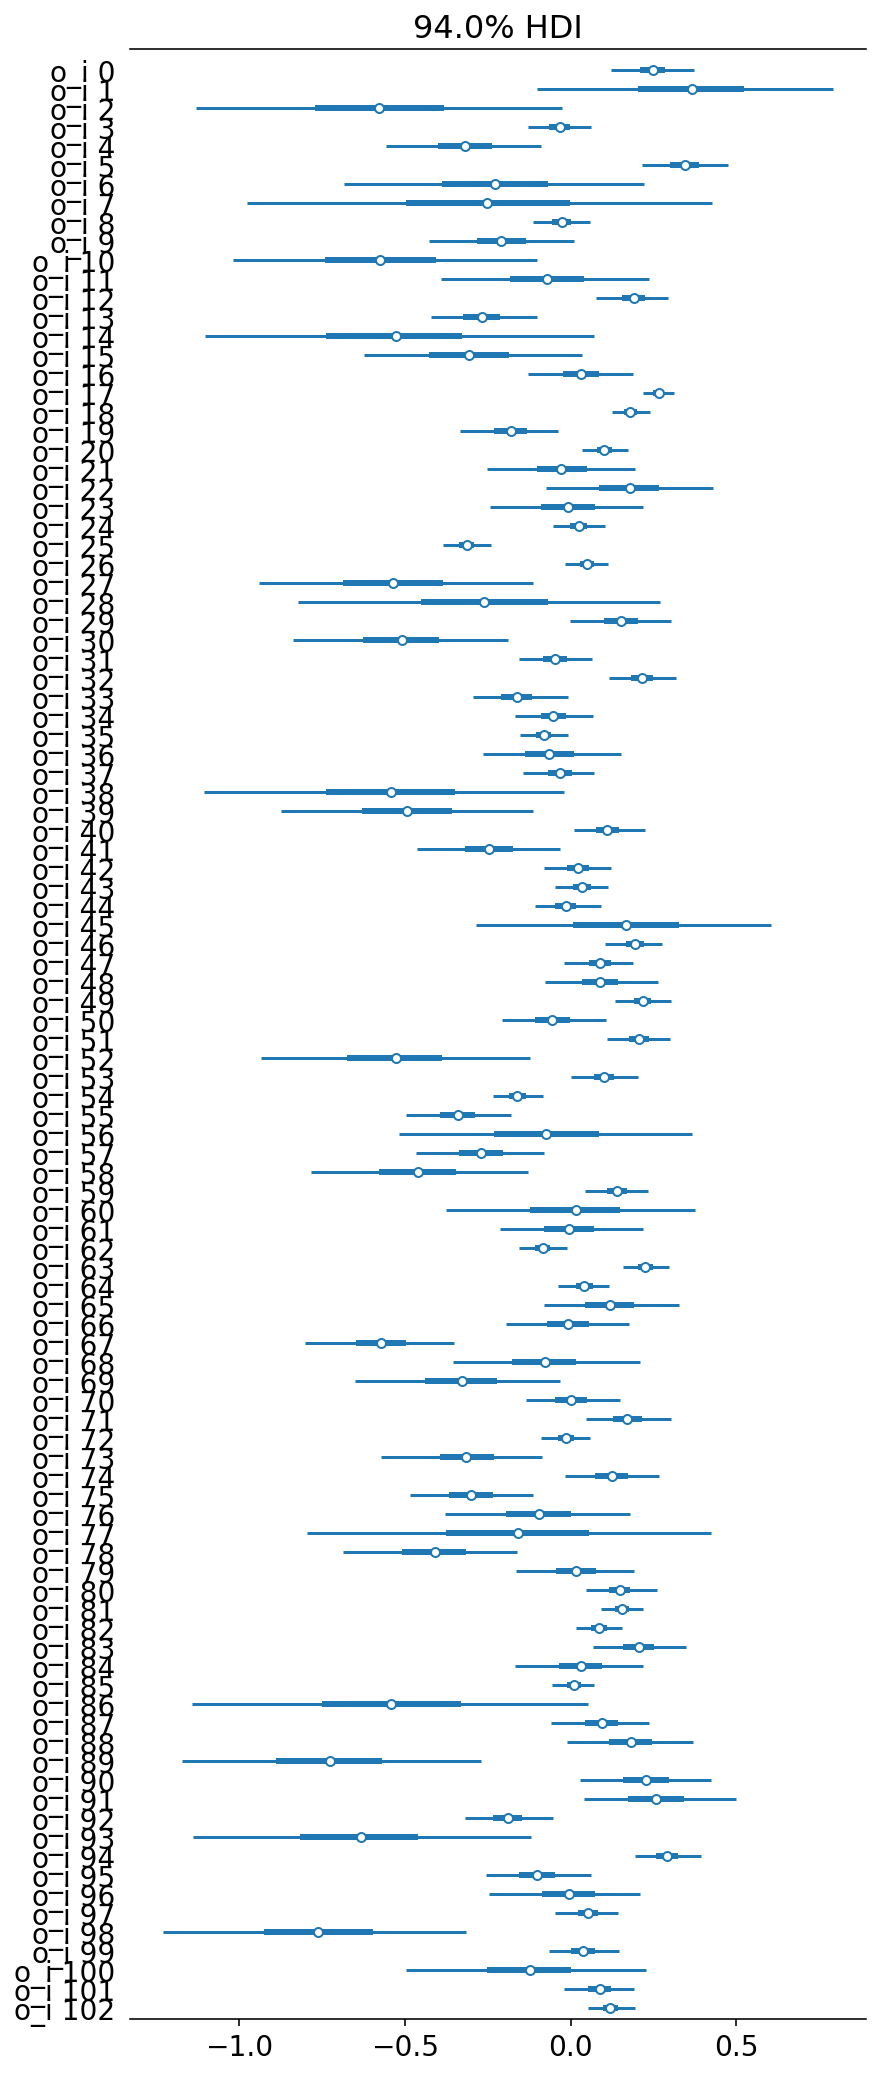

In [14]:
az.plot_forest(az_ceres_m1, var_names="o_i", combined=True)
plt.show()

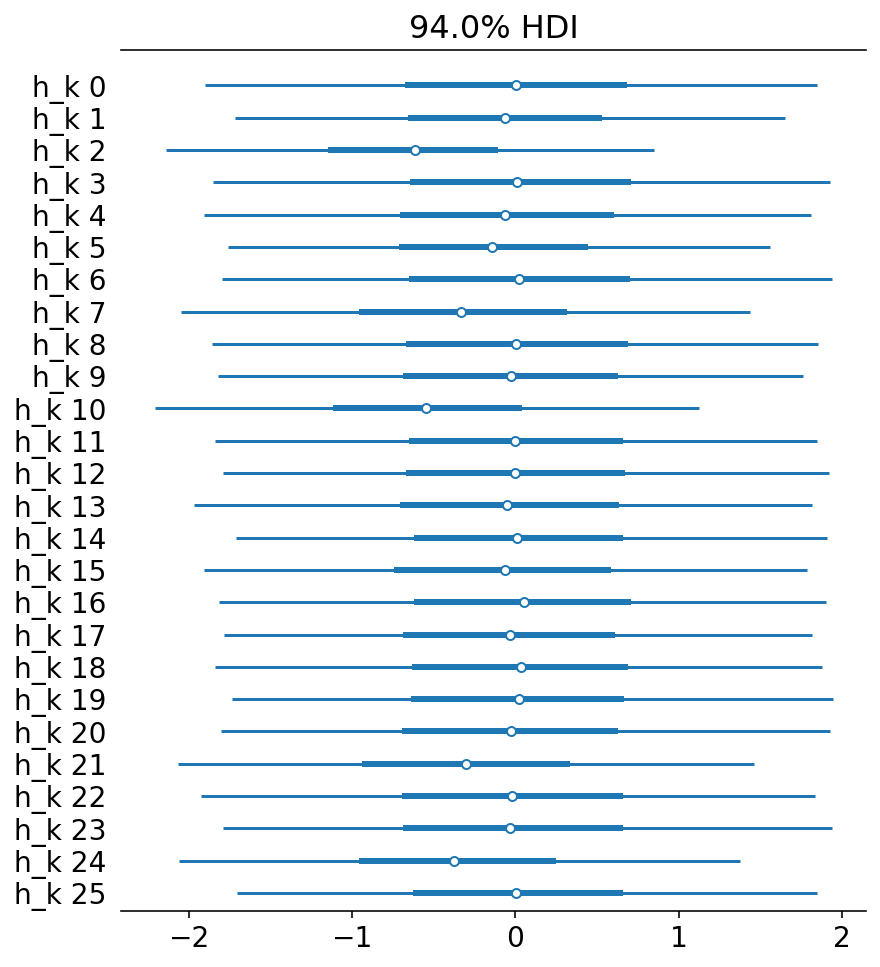

In [15]:
az.plot_forest(az_ceres_m1, var_names="h_k", combined=True)
plt.show()

In [16]:
gene_effect_post = ceres_m1_samples["trace"].get_values("g_kj")
gene_effect_post.shape

(9000, 26, 86)

In [17]:
gene_effect_mean = gene_effect_post.mean(axis=0)
gene_effect_mean.shape

(26, 86)

In [18]:
gene_effect_post_df = (
    pd.DataFrame(gene_effect_mean)
    .reset_index()
    .rename(columns={"index": "gene_idx"})
    .melt(id_vars="gene_idx", var_name="cell_line_idx", value_name="gene_effect")
    .assign(
        hugo_symbol=lambda d: [
            data["hugo_symbol"].values.categories[i] for i in d["gene_idx"].values
        ],
        depmap_id=lambda d: [
            data["depmap_id"].values.categories[i] for i in d["cell_line_idx"].values
        ],
    )
)

cols = ["depmap_id", "kras_mutation", "is_deleterious"]
mutation_info = data[cols].drop_duplicates()
mutation_info[cols[:-1]] = mutation_info[cols[:-1]].astype("str")

gene_effect_post_df = gene_effect_post_df.merge(
    mutation_info, how="left", on=["depmap_id"]
)

gene_effect_post_df.head(n=7)

gene_idx cell_line_idx  gene_effect hugo_symbol   depmap_id kras_mutation  \
0         0             0     1.189885       PDE5A  ACH-000757          G12D   
1         0             0     1.189885       PDE5A  ACH-000757          G12D   
2         1             0     0.933719        TP53  ACH-000757          G12D   
3         1             0     0.933719        TP53  ACH-000757          G12D   
4         2             0    -1.244338        KRAS  ACH-000757          G12D   
5         2             0    -1.244338        KRAS  ACH-000757          G12D   
6         3             0     0.993389       KIF3C  ACH-000757          G12D   

  is_deleterious  
0            NaN  
1          FALSE  
2            NaN  
3          FALSE  
4            NaN  
5          FALSE  
6            NaN

In [19]:
data.is_deleterious.unique()

array([nan, 'FALSE', 'TRUE', 'FALSE;TRUE', 'FALSE;FALSE;FALSE',
       'TRUE;TRUE;FALSE', 'FALSE;FALSE', 'FALSE;FALSE;TRUE;FALSE;TRUE',
       'TRUE;TRUE', 'FALSE;TRUE;TRUE', 'FALSE;TRUE;FALSE', 'TRUE;FALSE'],
      dtype=object)

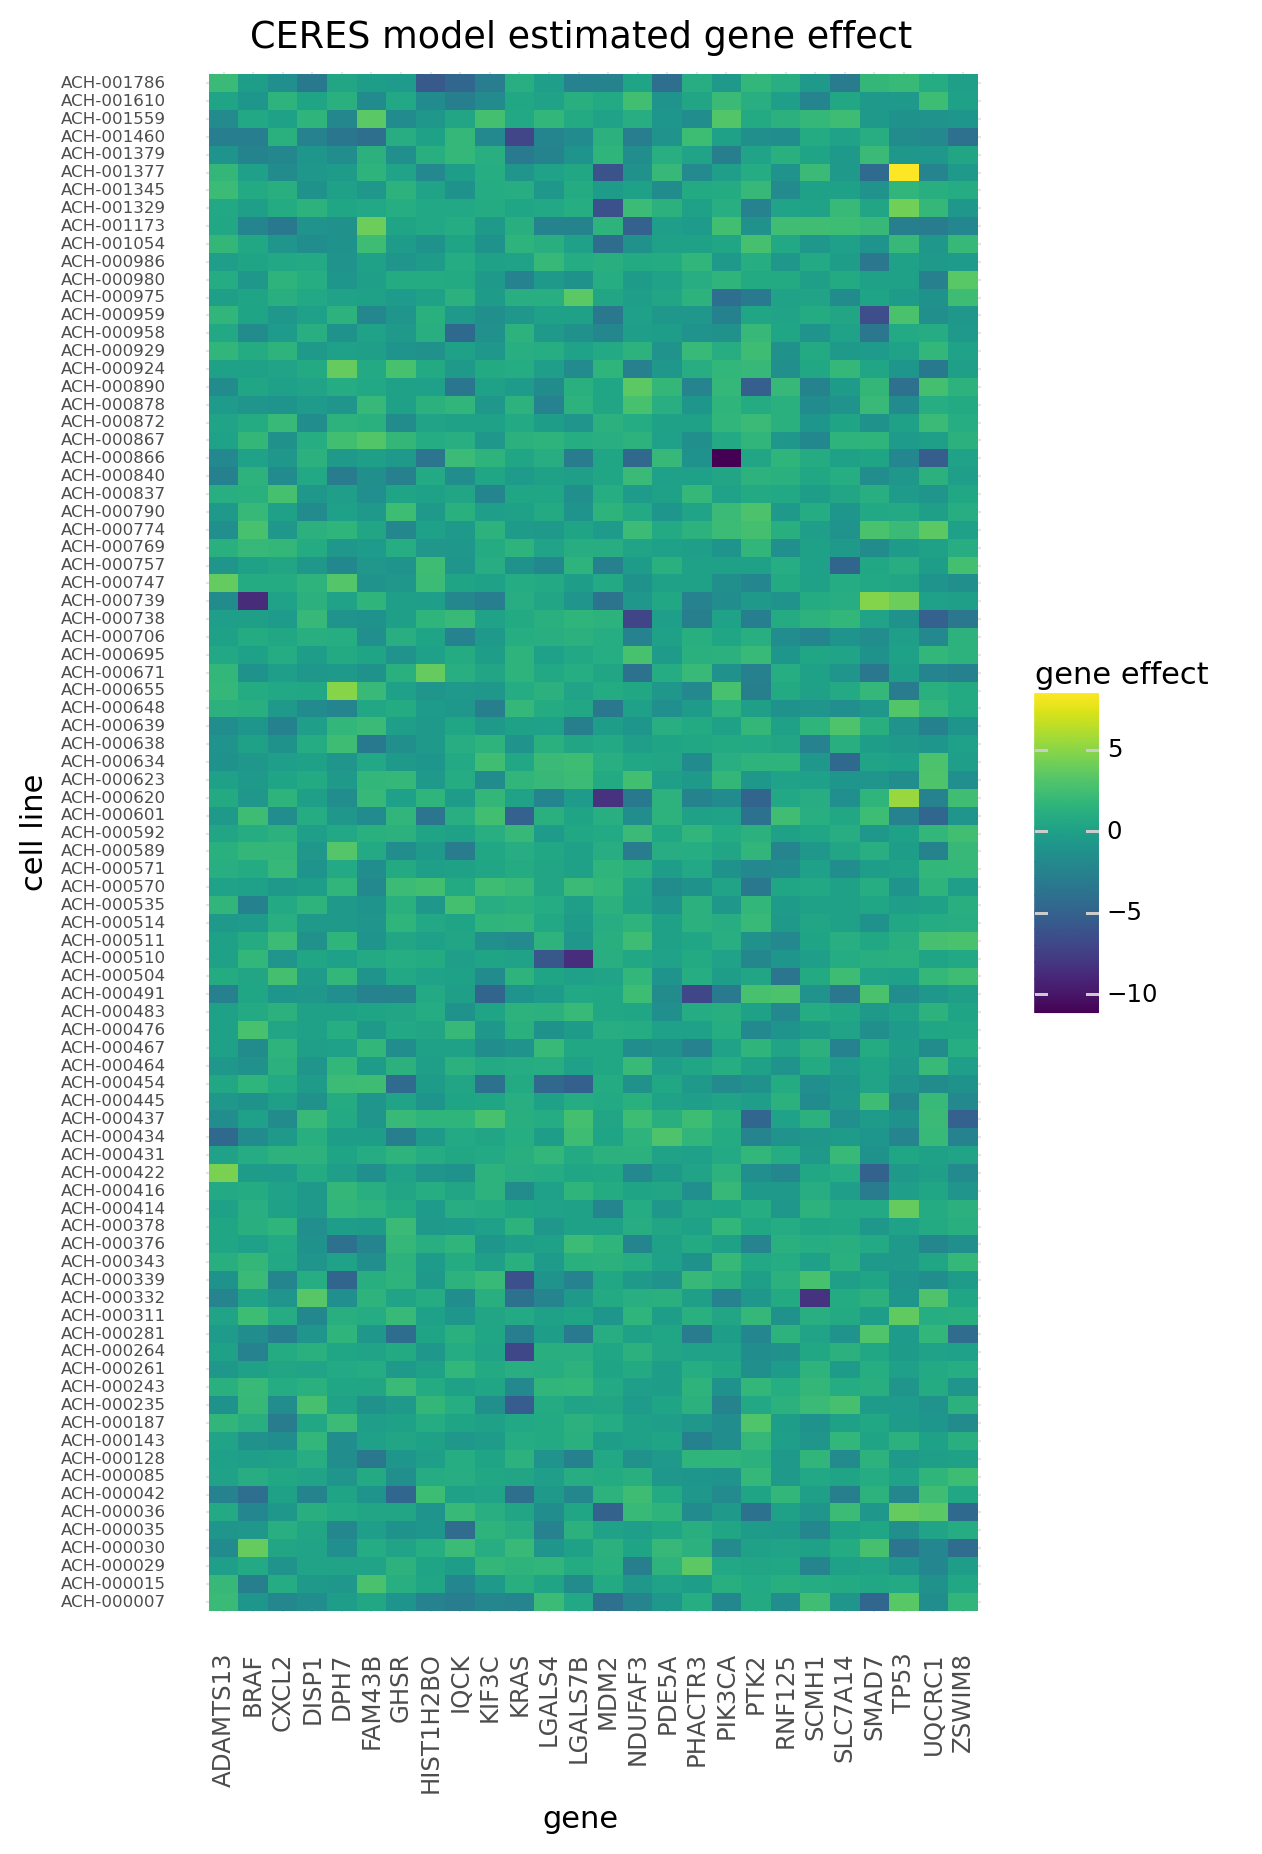

<ggplot: (8768007899832)>

In [20]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="hugo_symbol", y="depmap_id"))
    + gg.geom_tile(gg.aes(fill="gene_effect"))
    + gg.theme(
        figure_size=(5, 10),
        axis_text_x=gg.element_text(angle=90),
        axis_text_y=gg.element_text(size=6),
    )
    + gg.labs(
        x="gene",
        y="cell line",
        fill="gene effect",
        title="CERES model estimated gene effect",
    )
)

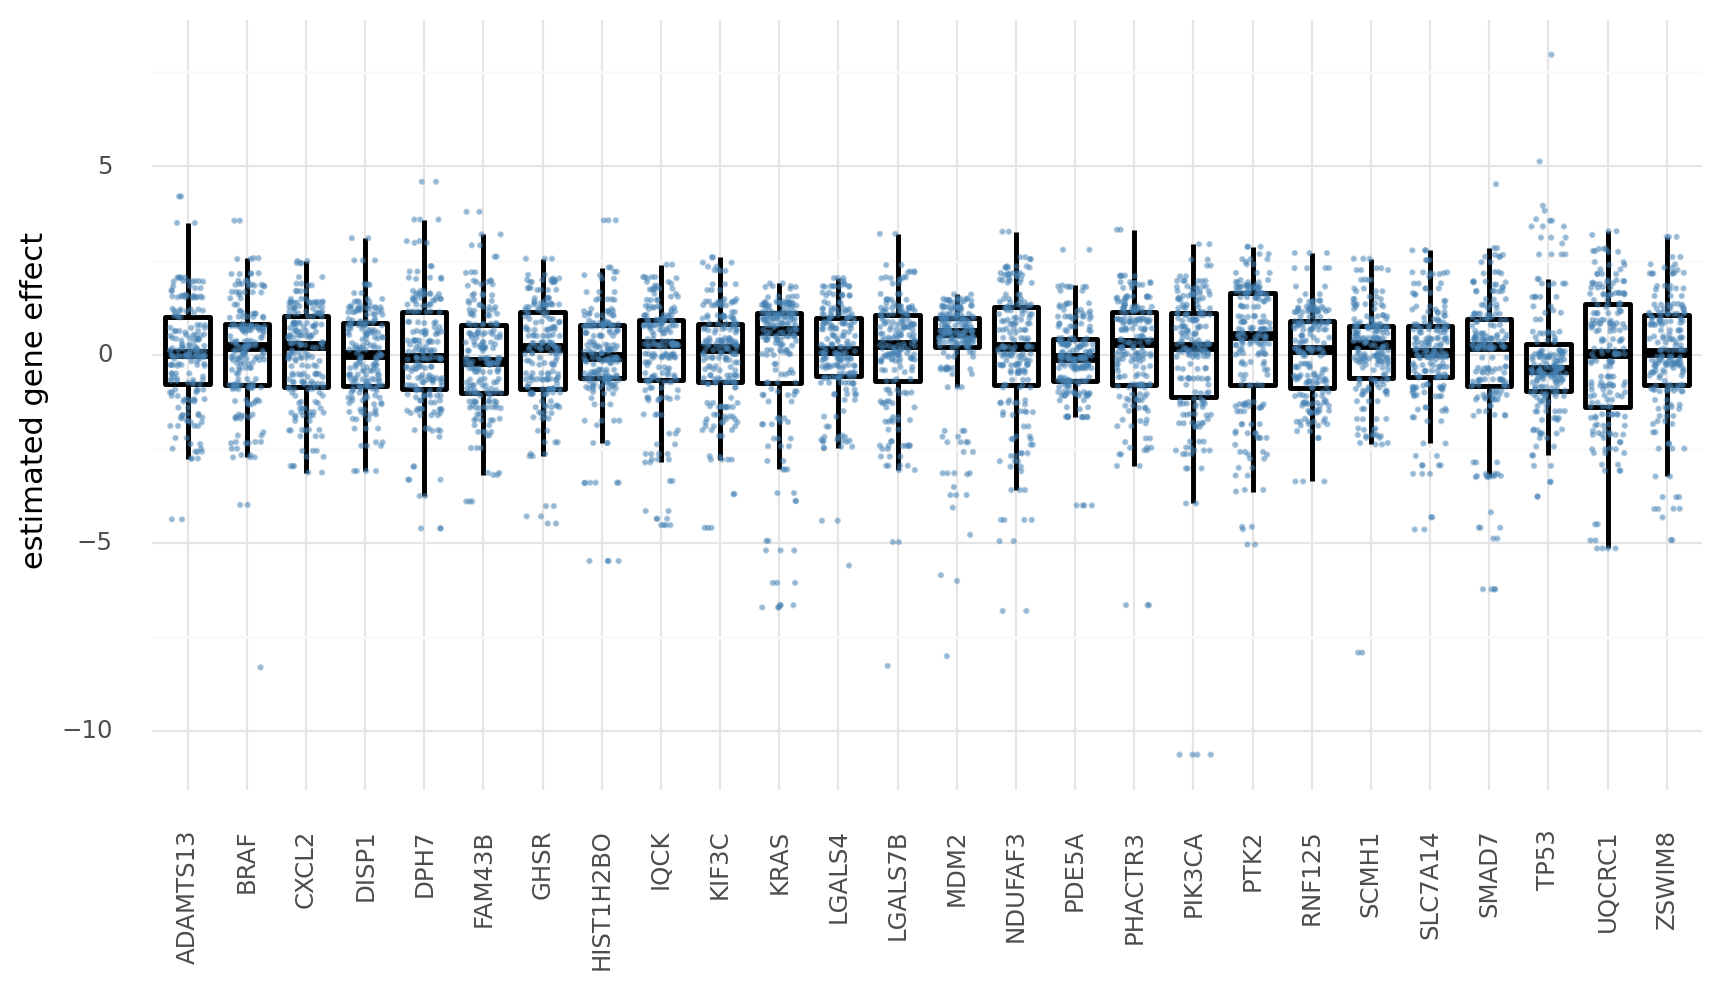

<ggplot: (8767733980151)>

In [21]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="hugo_symbol", y="gene_effect"))
    + gg.geom_boxplot(alpha=0, color="black", outlier_alpha=0, size=1)
    + gg.geom_jitter(alpha=0.4, size=0.3, height=0, width=0.3, color="steelblue")
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1), figure_size=(10, 5)
    )
    + gg.labs(x=None, y="estimated gene effect")
)

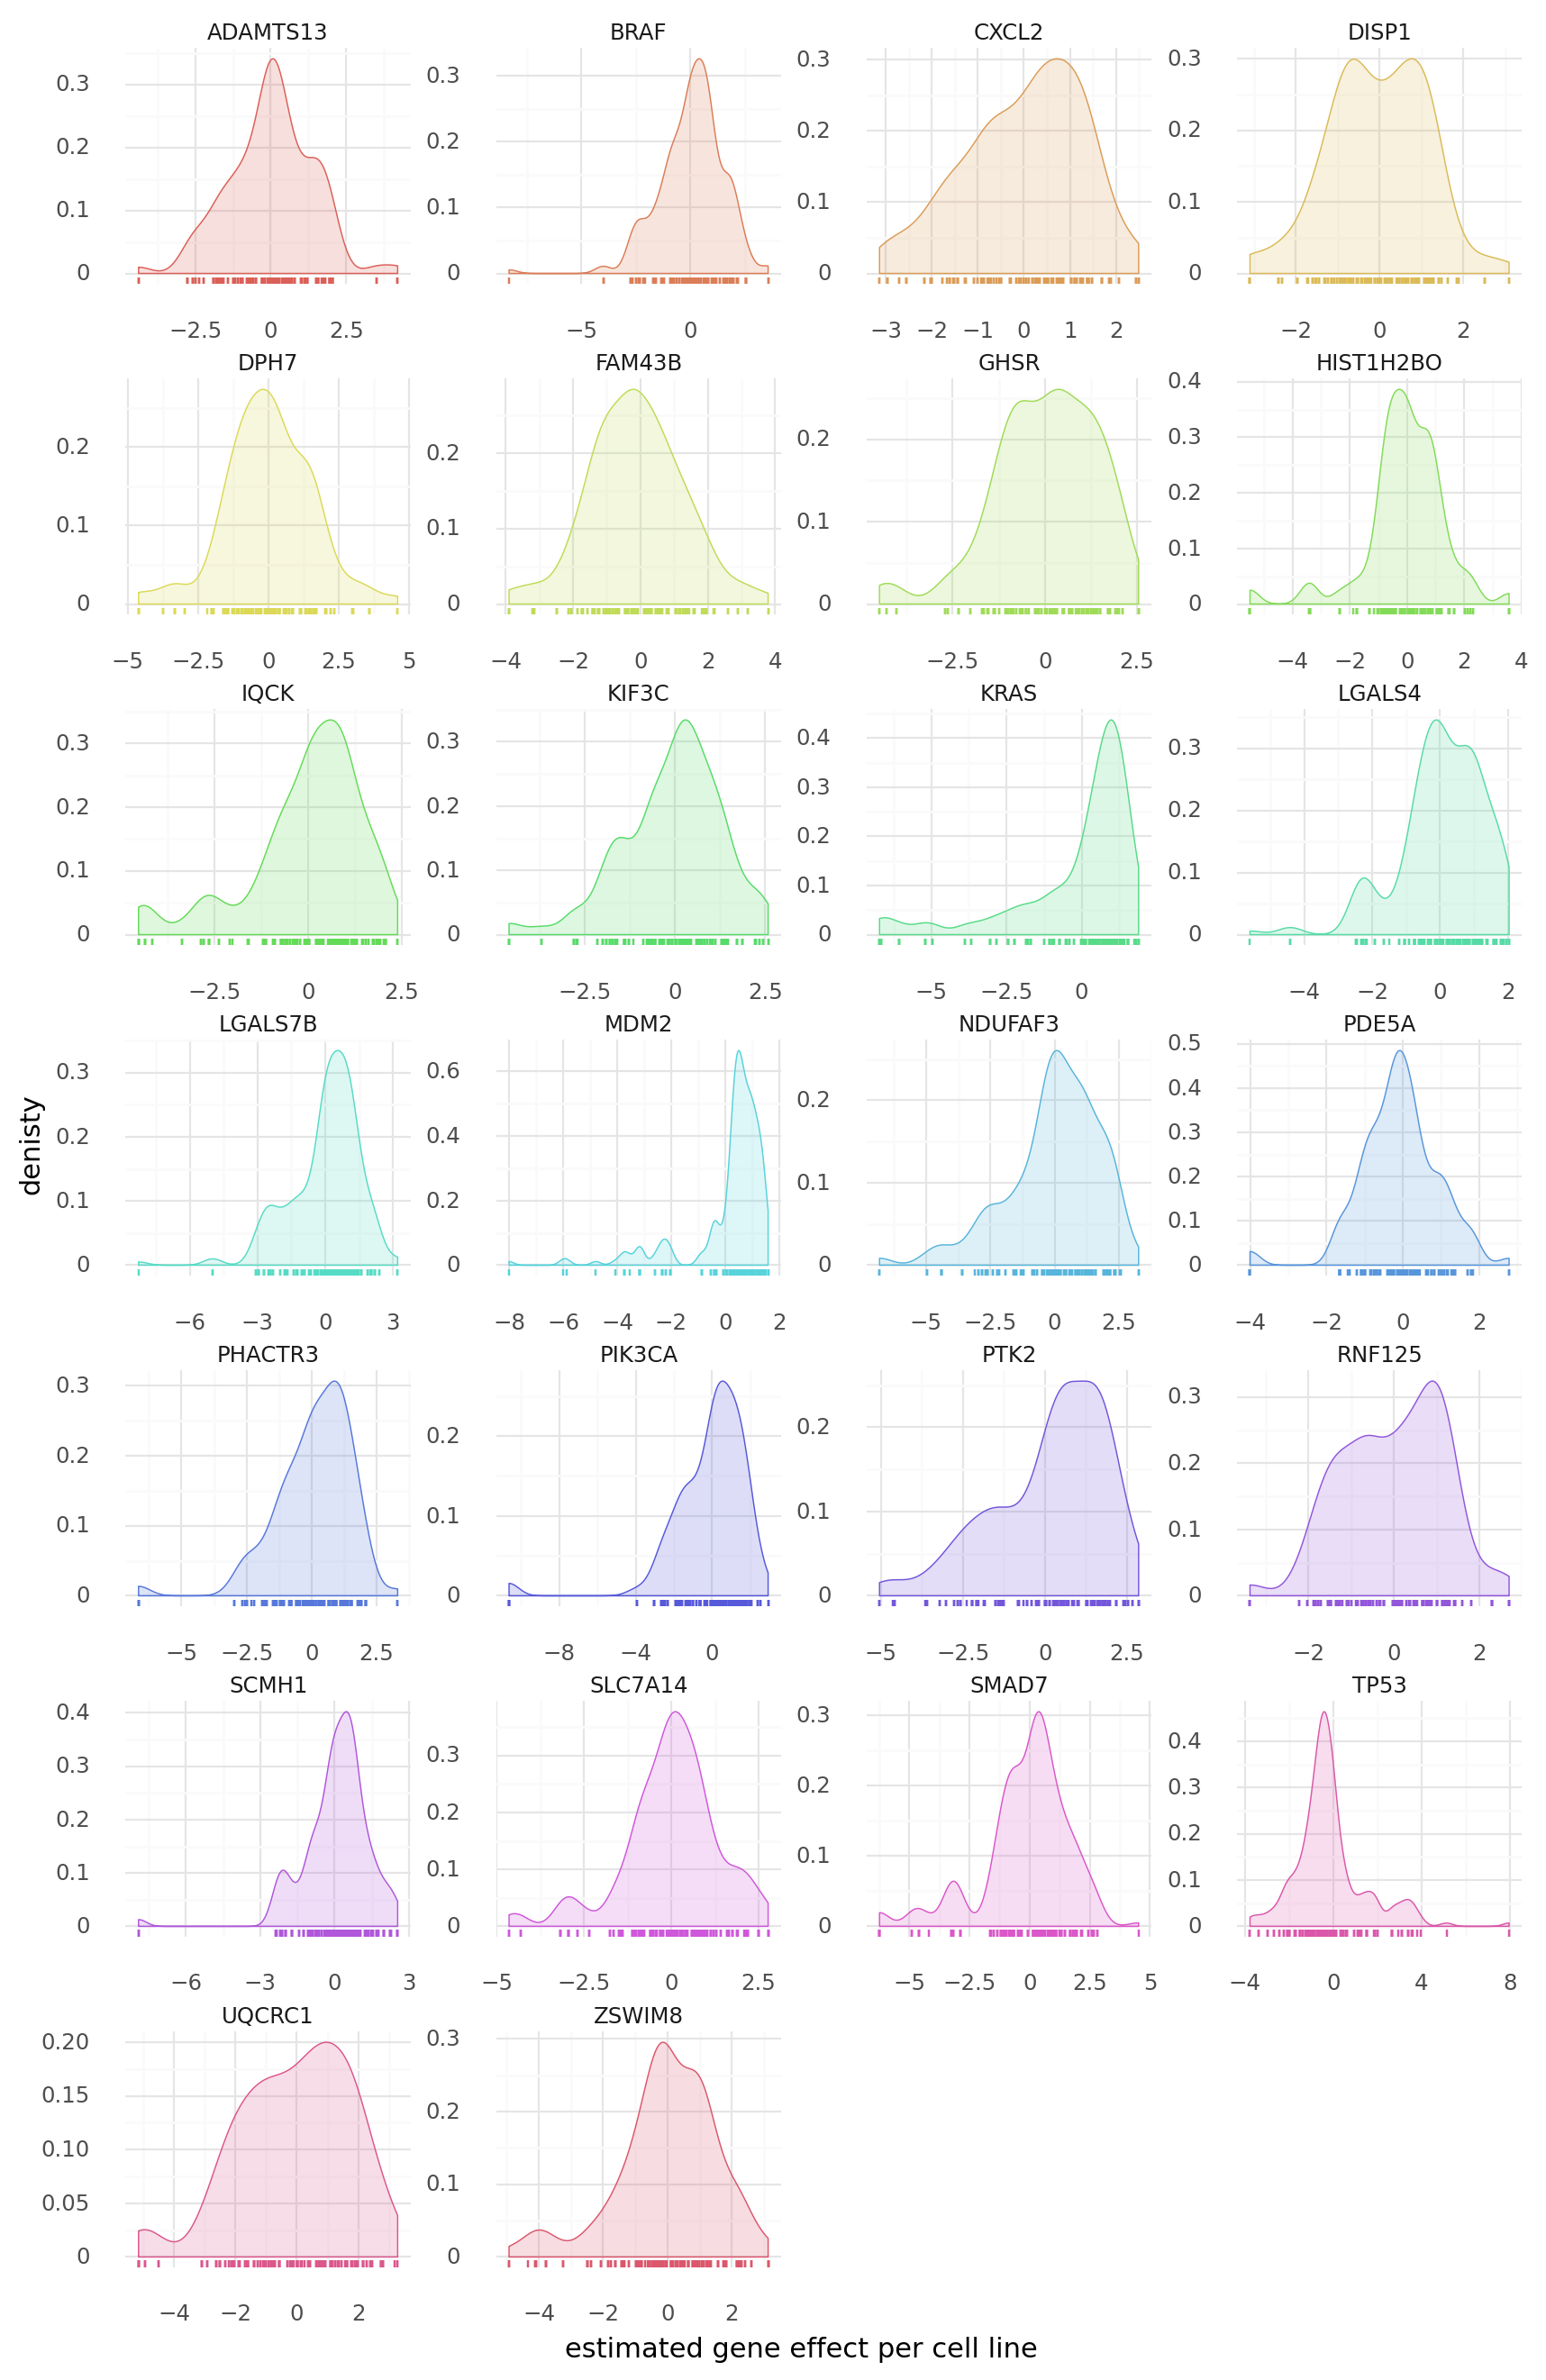

<ggplot: (8768004622873)>

In [22]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="gene_effect"))
    + gg.facet_wrap("hugo_symbol", ncol=4, scales="free")
    + gg.geom_density(
        gg.aes(color="hugo_symbol", fill="hugo_symbol"), alpha=0.2, size=0.3
    )
    + gg.geom_rug(gg.aes(color="hugo_symbol"))
    + gg.theme(
        figure_size=(10, 16),
        legend_position="none",
        subplots_adjust={"hspace": 0.4, "wspace": 0.3},
    )
    + gg.labs(x="estimated gene effect per cell line", y="denisty")
)

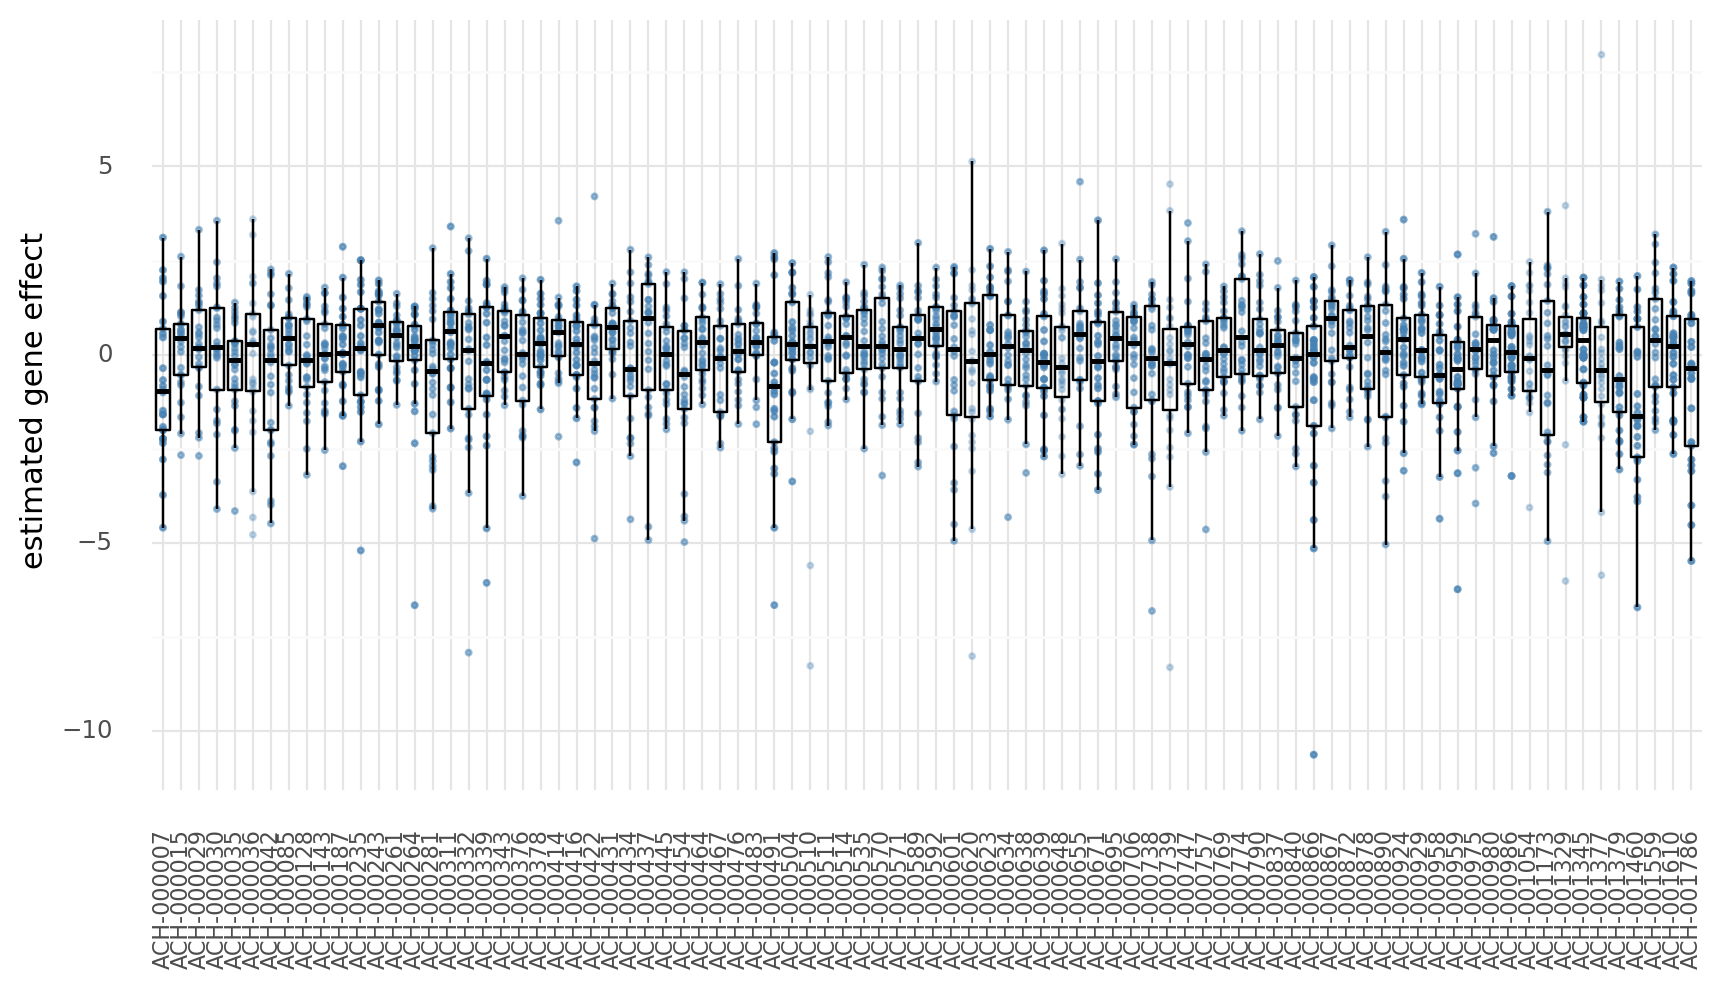

<ggplot: (8767733544223)>

In [23]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="depmap_id", y="gene_effect"))
    + gg.geom_jitter(alpha=0.3, size=0.6, height=0, width=0, color="steelblue")
    + gg.geom_boxplot(alpha=0, color="black", outlier_alpha=0)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1, size=8),
        figure_size=(10, 5),
    )
    + gg.labs(x=None, y="estimated gene effect")
)

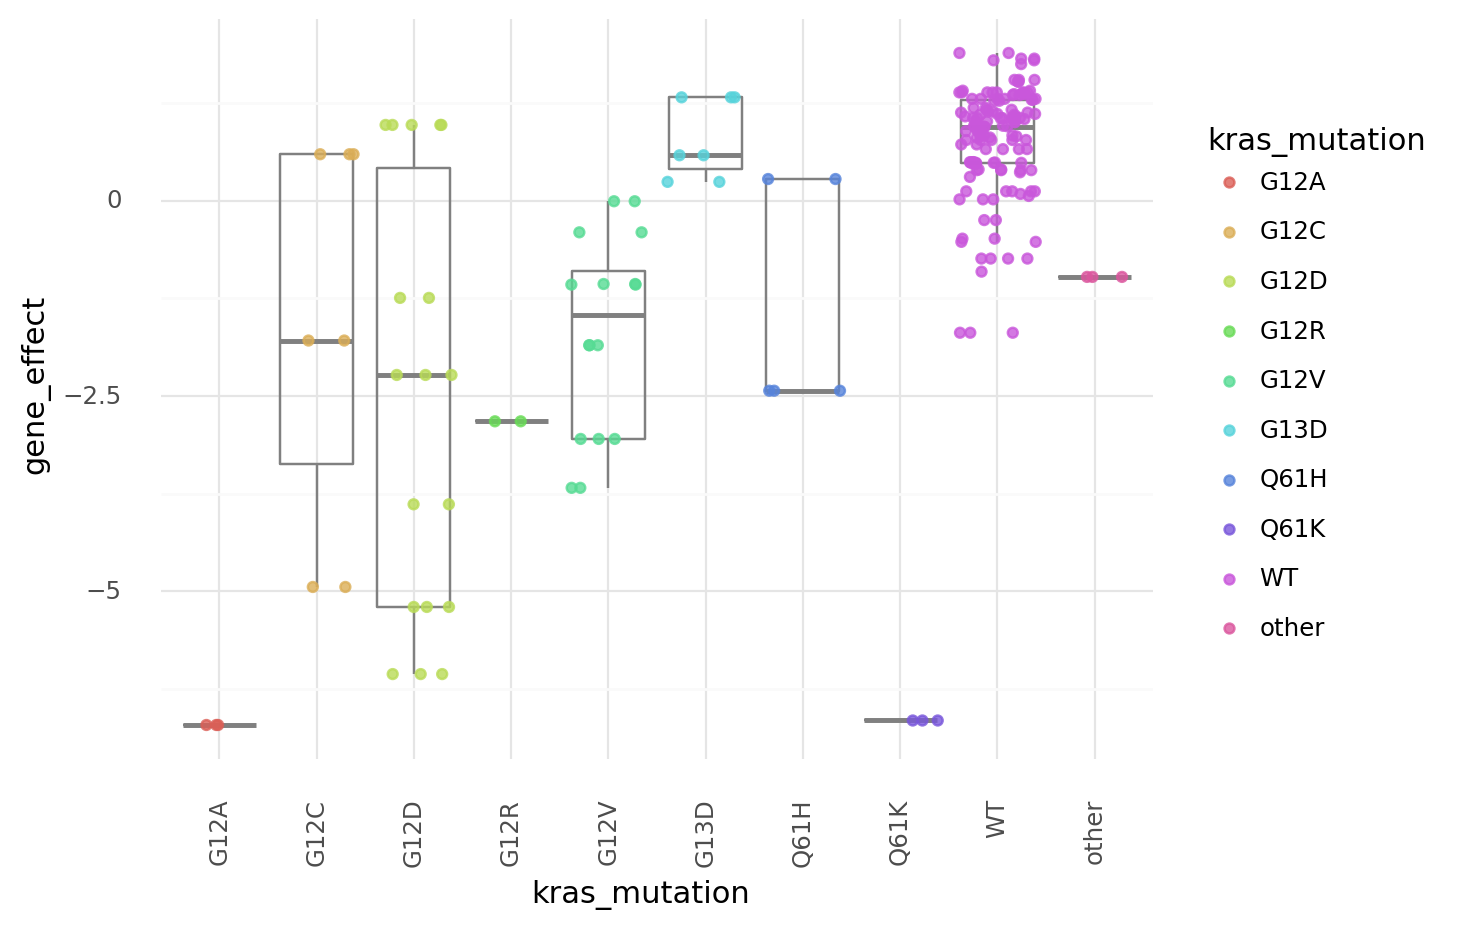

<ggplot: (8767733814736)>

In [24]:
kras_gene_effect = gene_effect_post_df[
    gene_effect_post_df.hugo_symbol == "KRAS"
].reset_index(drop=True)

(
    gg.ggplot(kras_gene_effect, gg.aes(x="kras_mutation", y="gene_effect"))
    + gg.geom_boxplot(alpha=0, color="gray", outlier_alpha=0)
    + gg.geom_jitter(gg.aes(color="kras_mutation"), width=0.4, height=0, alpha=0.8)
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1))
)

---

### Model 2.

Below is the model that will be fit with PyMC3 as the mimic of CERES with a covariate for the gene CN modeled as a standard linear coefficient.
The copy number values were z-scaled within each gene.

$
\quad D_{ij} \sim \mathcal{N}(\mu_{ij}, \epsilon) \\
\quad \mu_{ij} = q_i \lgroup h_k + g_{kj} + \beta_{ij} C \rgroup + o_i \\
\qquad q_i \sim \text{Beta}(2, 2) \\
\qquad h_k \sim \mathcal{N}(0, 1) \\
\qquad g_{kj} \sim \mathcal{N}(0, 1) \\
\qquad o_i \sim \mathcal{N}(0, 1) \\
\quad \epsilon \sim \text{Exp}(1)
$

In [25]:
BATCH_SIZE = 100
sgrna_idx_mb = pm.Minibatch(sgrna_idx, batch_size=BATCH_SIZE)
gene_idx_mb = pm.Minibatch(gene_idx, batch_size=BATCH_SIZE)
cell_line_idx_mb = pm.Minibatch(cell_line_idx, batch_size=BATCH_SIZE)

gene_cn_z_mb = pm.Minibatch(data.gene_cn_z.to_numpy(), batch_size=BATCH_SIZE)
lfc_mb = pm.Minibatch(data.lfc.to_numpy(), batch_size=BATCH_SIZE)

with pm.Model() as ceres_m2:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 2, shape=(num_genes, num_cell_lines))
    beta_ij = pm.Normal("beta_ij", -0.5, 1, shape=(num_sgrnas, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = pm.Deterministic(
        "mu",
        q_i[sgrna_idx_mb]
        * (
            h_k[gene_idx_mb]
            + g_kj[gene_idx_mb, cell_line_idx_mb]
            + beta_ij[sgrna_idx_mb, cell_line_idx_mb] * gene_cn_z_mb
        )
        + o_i[sgrna_idx_mb],
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=lfc_mb, total_size=len(data))

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/pymc3/data.py:307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/pymc3/data.py:307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(s

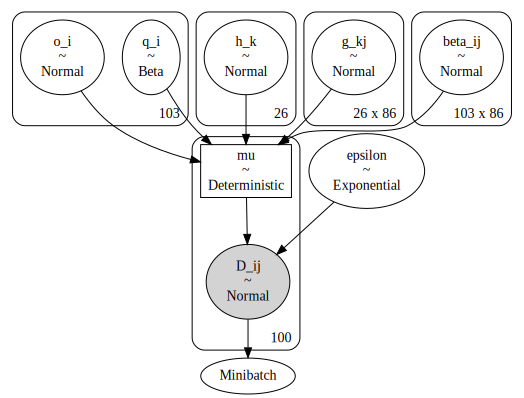

In [26]:
pm.model_to_graphviz(ceres_m2)

In [27]:
%%time

with ceres_m2:
    ceres_m2_advi_meanfield = pm.fit(
        40000,
        method="advi",
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)],
        random_seed=RANDOM_SEED,
    )

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Finished [100%]: Average Loss = 92.68


CPU times: user 2min 34s, sys: 13.5 s, total: 2min 48s
Wall time: 4min 14s


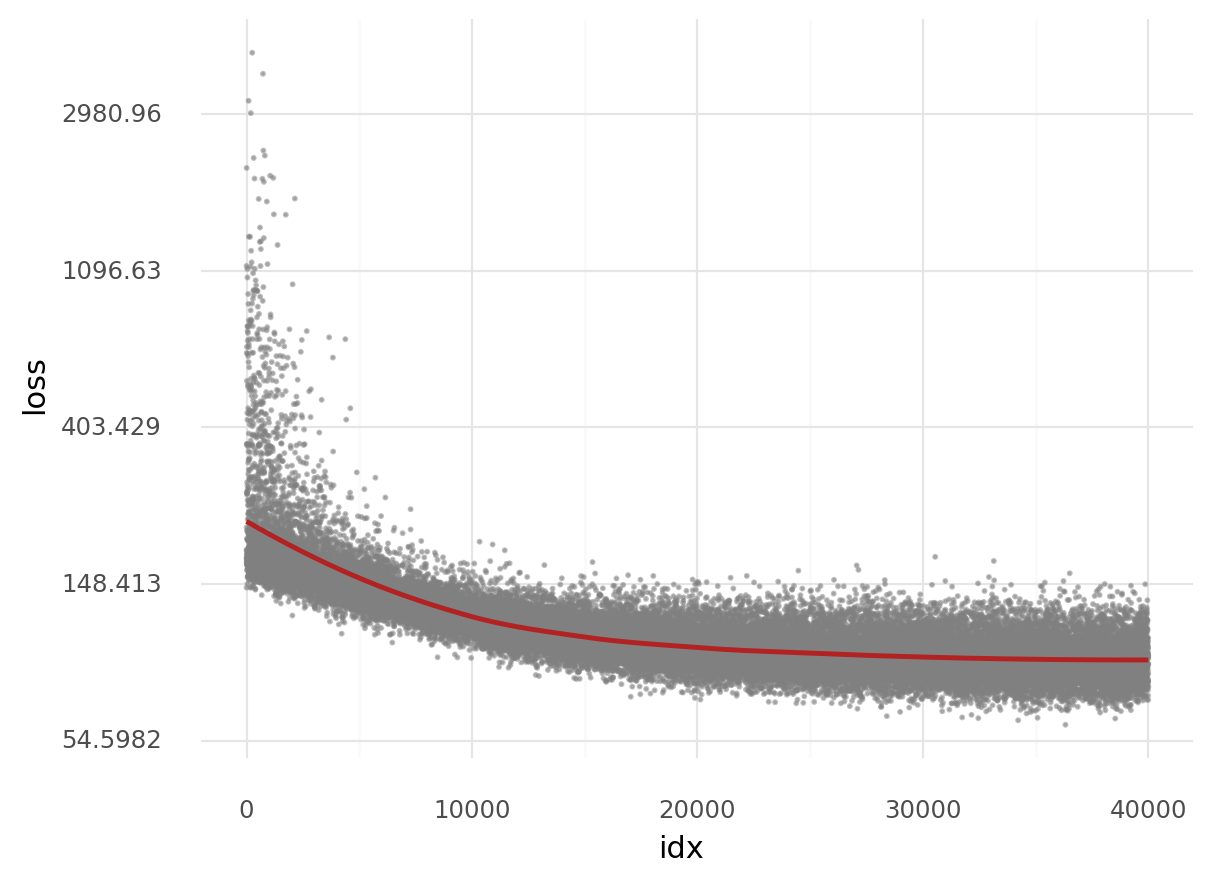

<ggplot: (8767723087035)>

In [28]:
df = pd.DataFrame(
    {
        "loss": ceres_m2_advi_meanfield.hist,
        "idx": range(len(ceres_m2_advi_meanfield.hist)),
    }
)
(
    gg.ggplot(df, gg.aes(x="idx", y="loss"))
    + gg.geom_point(color="gray", alpha=0.5, size=0.2)
    + gg.geom_smooth(method="loess", se=False, color="firebrick")
    + gg.scale_y_continuous(trans="log")
)

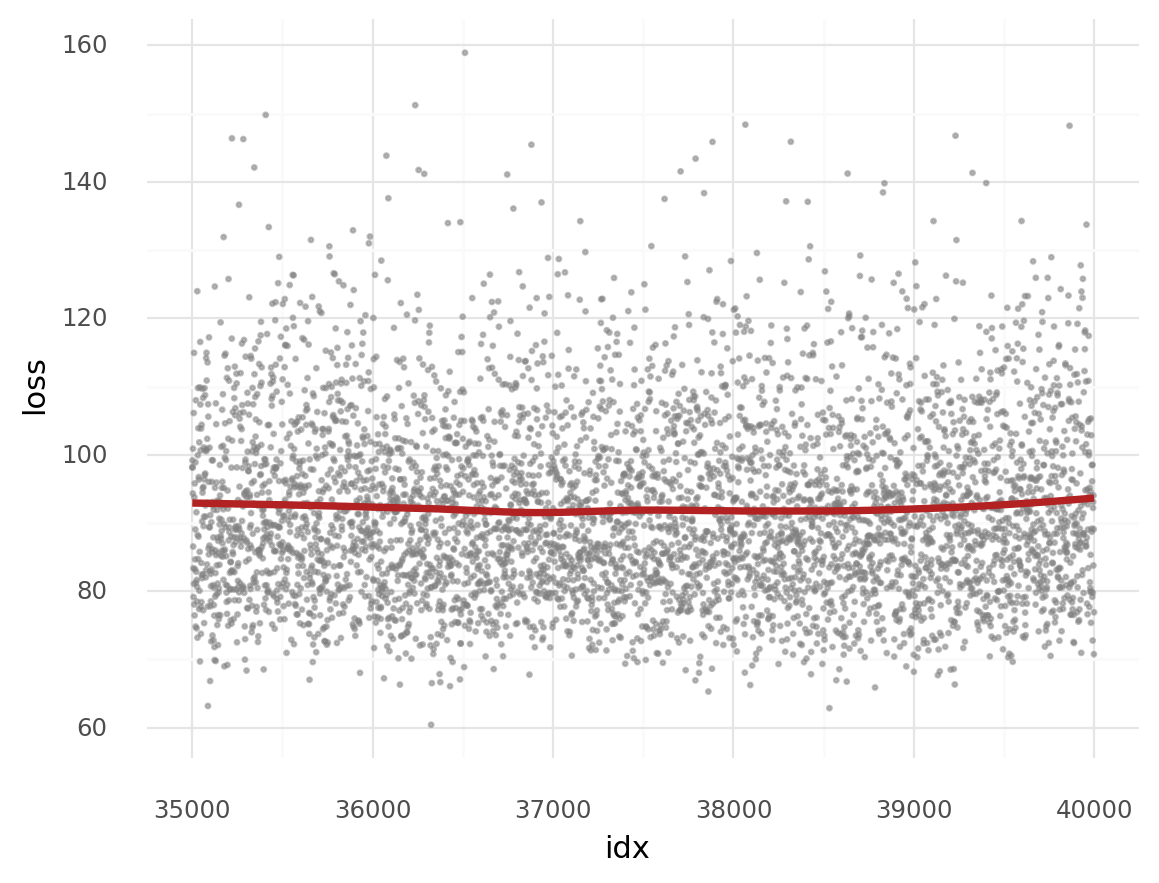

<ggplot: (8767734001297)>

In [29]:
(
    gg.ggplot(df.tail(n=5000), gg.aes(x="idx", y="loss"))
    + gg.geom_point(color="gray", alpha=0.5, size=0.4)
    + gg.geom_smooth(method="loess", se=False, color="firebrick", size=1.5)
)

In [30]:
with pm.Model() as ceres_m2_full:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 2, shape=(num_genes, num_cell_lines))
    beta_ij = pm.Normal("beta_ij", -0.5, 1, shape=(num_sgrnas, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = pm.Deterministic(
        "mu",
        q_i[sgrna_idx]
        * (
            h_k[gene_idx]
            + g_kj[gene_idx, cell_line_idx]
            + beta_ij[sgrna_idx, cell_line_idx] * data.gene_cn_z.values
        )
        + o_i[sgrna_idx],
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=data.lfc.values)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [31]:
%%time

ceres_m2_mcmc_cachedir = pymc3_cache_dir / "ceres_m2_mcmc"

ceres_m2_mcmc_res = pmhelp.pymc3_sampling_procedure(
    model=ceres_m2_full,
    num_mcmc=2000,
    tune=2000,
    chains=2,
    cores=1,
    random_seed=RANDOM_SEED,
    cache_dir=ceres_m2_mcmc_cachedir,
    sample_kwags={},  # REMOVE THIS ARG NEXT TIME (FIXED)
)

Loading cached trace and posterior sample...


/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


CPU times: user 5.99 s, sys: 1.68 s, total: 7.67 s
Wall time: 14.9 s


In [32]:
az_ceres_m2 = az.from_pymc3(
    trace=ceres_m2_mcmc_res["trace"],
    model=ceres_m2_full,
    posterior_predictive=ceres_m2_mcmc_res["posterior_predictive"],
    prior=ceres_m2_mcmc_res["prior_predictive"],
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
arviz.data.io_pymc3 - WARNING - posterior predictive variable D_ij's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [33]:
%%time

ceres_m2_mcmc_advi_cachedir = pymc3_cache_dir / "ceres_m2_mcmc_advi"

ceres_m2_mcmc_advi_res = pmhelp.pymc3_sampling_procedure(
    model=ceres_m2_full,
    num_mcmc=2000,
    tune=2000,
    chains=2,
    cores=1,
    random_seed=RANDOM_SEED,
    cache_dir=ceres_m2_mcmc_advi_cachedir,
    sample_kwags={"init": "advi", "n_init": 40000},
)

Loading cached trace and posterior sample...
CPU times: user 5.81 s, sys: 1.47 s, total: 7.28 s
Wall time: 12.2 s


In [34]:
az_ceres_m2_advi = az.from_pymc3(
    trace=ceres_m2_mcmc_advi_res["trace"],
    model=ceres_m2_full,
    posterior_predictive=ceres_m2_mcmc_advi_res["posterior_predictive"],
    prior=ceres_m2_mcmc_advi_res["prior_predictive"],
)

arviz.data.io_pymc3 - WARNING - posterior predictive variable D_ij's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


### Compare ADVI, MCMC, ADVI + MCMC

In [35]:
# Sample from posterior of ADVI fit.
np.random.seed(RANDOM_SEED)
ceres_m2_advi_sample = ceres_m2_advi_meanfield.sample(1000)


def mod_az_summary(df, trace_lbl):
    colname_changes = {
        "index": "variable",
        "hdi_5.5%": "hdi_lower",
        "hdi_94.5%": "hdi_upper",
    }
    keep_cols = ["trace", "variable", "mean", "hdi_lower", "hdi_upper"]
    mod_df = (
        df.reset_index(drop=False)
        .rename(columns=colname_changes)
        .assign(trace=trace_lbl)[keep_cols]
    )
    return mod_df


def mod_advi_summary(df, trace_lbl="ADVI"):
    return df.assign(trace=trace_lbl)


def summarise_advi_sample(ary, axis=0, hdi_prob=0.89):
    means = ary.mean(axis=axis)
    hdi = az.hdi(ary, hdi_prob=hdi_prob)
    return pd.DataFrame({"mean": means, "hdi_lower": hdi[:, 0], "hdi_upper": hdi[:, 1]})


def get_merged_posterior(var_name):
    mcmc_post = az.summary(az_ceres_m2, var_names=var_name, hdi_prob=0.89)
    mcmc_advi_post = az.summary(az_ceres_m2_advi, var_names=var_name, hdi_prob=0.89)
    advi_post = summarise_advi_sample(ceres_m2_advi_sample[var_name])
    advi_post["variable"] = mcmc_post.index.values

    merged_post = pd.concat(
        [
            mod_az_summary(mcmc_post, "MCMC"),
            mod_az_summary(mcmc_advi_post, "ADVI + MCMC"),
            mod_advi_summary(advi_post),
        ]
    ).reset_index(drop=True)
    merged_post["variable"] = pd.Categorical(
        merged_post["variable"],
        categories=mcmc_post.index.values,
        ordered=True,
    )

    return merged_post

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [36]:
merged_qi_posterior = get_merged_posterior("q_i")
merged_qi_posterior.head()

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


trace variable   mean  hdi_lower  hdi_upper
0  MCMC   q_i[0]  0.052      0.022      0.083
1  MCMC   q_i[1]  0.213      0.185      0.238
2  MCMC   q_i[2]  0.308      0.276      0.346
3  MCMC   q_i[3]  0.038      0.015      0.060
4  MCMC   q_i[4]  0.108      0.081      0.132

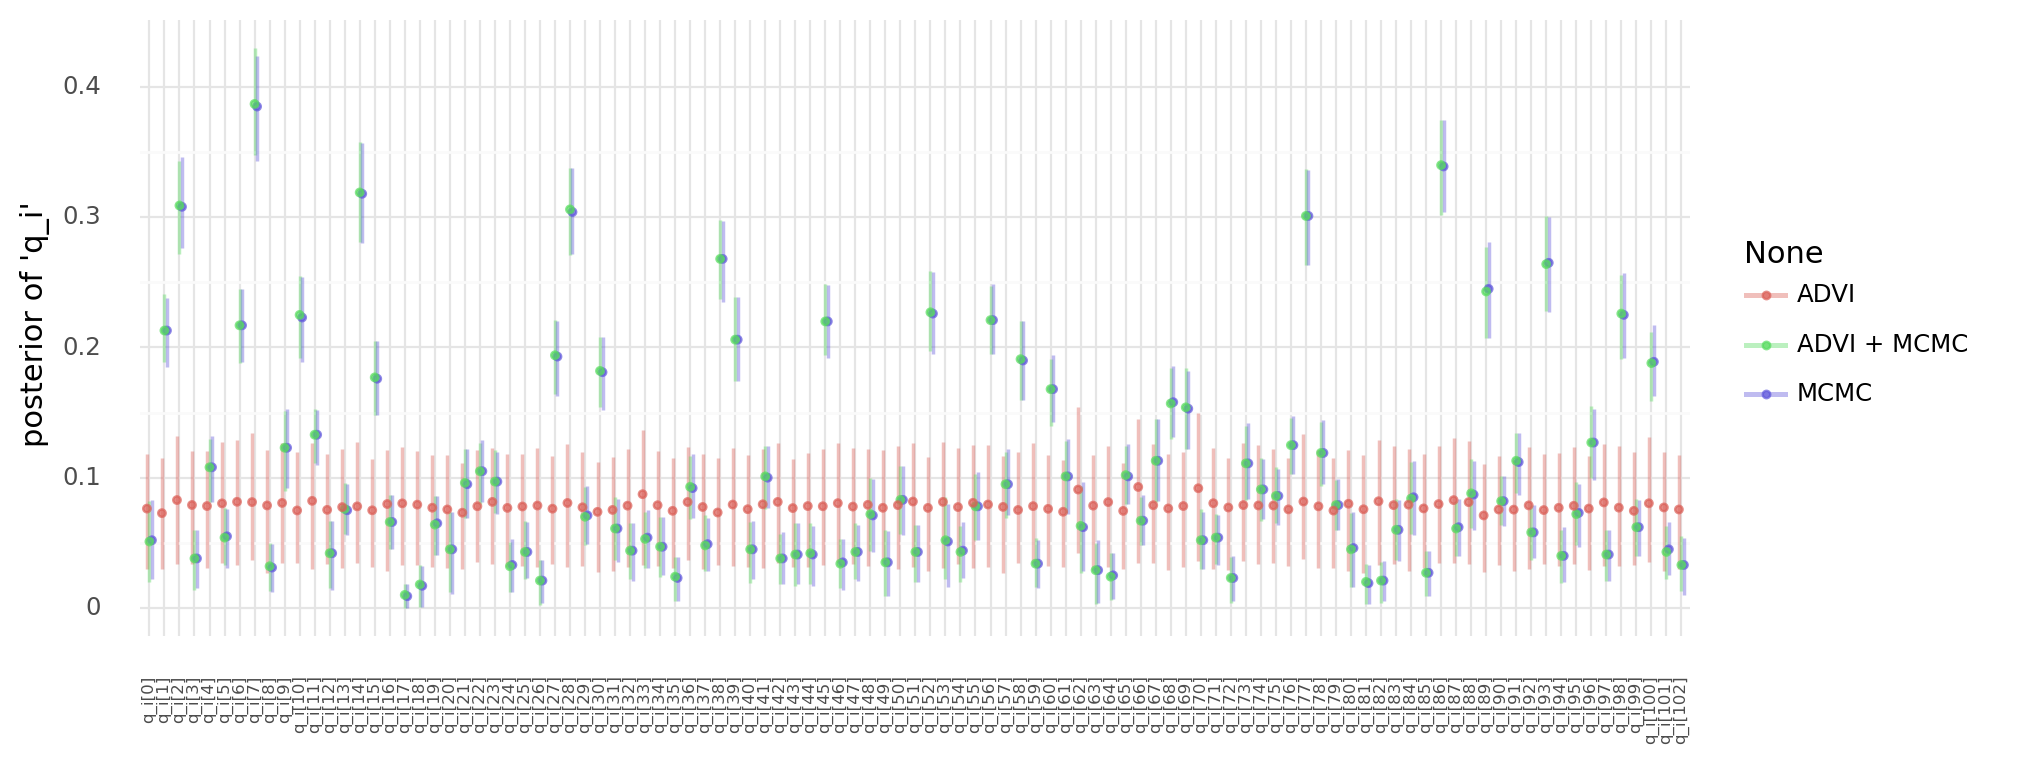

<ggplot: (8767719904401)>

In [37]:
pos = gg.position_dodge(width=0.5)

(
    gg.ggplot(merged_qi_posterior, gg.aes(x="variable"))
    + gg.geom_linerange(
        gg.aes(ymin="hdi_lower", ymax="hdi_upper", color="trace"),
        position=pos,
        size=0.7,
        alpha=0.4,
    )
    + gg.geom_point(gg.aes(y="mean", color="trace"), position=pos, size=1, alpha=0.7)
    + gg.theme(
        figure_size=(10, 4),
        axis_text_x=gg.element_text(size=6, angle=90, hjust=0.5, vjust=1),
        legend_position="right",
    )
    + gg.labs(x=None, y="posterior of 'q_i'", color=None)
)

## Comparing CERES with and without a covariate for CNA

In [38]:
var_names = ["q_i", "h_k", "g_kj", "o_i", "epsilon"]
ceres_m1_summary = az.summary(az_ceres_m1, var_names=var_names, hdi_prob=0.89)
ceres_m2_summary = az.summary(
    az_ceres_m2_advi, var_names=var_names + ["beta_ij"], hdi_prob=0.89
)

In [39]:
ceres_m2_summary

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
q_i[0]           0.051  0.020     0.020      0.082      0.001    0.000   
q_i[1]           0.213  0.016     0.189      0.241      0.001    0.000   
q_i[2]           0.309  0.022     0.272      0.343      0.002    0.001   
q_i[3]           0.038  0.014     0.014      0.060      0.000    0.000   
q_i[4]           0.108  0.016     0.081      0.130      0.000    0.000   
...                ...    ...       ...        ...        ...      ...   
beta_ij[102,81] -0.469  0.970    -2.056      1.051      0.010    0.015   
beta_ij[102,82] -0.499  0.956    -2.090      0.979      0.010    0.016   
beta_ij[102,83] -0.381  0.998    -1.972      1.193      0.010    0.018   
beta_ij[102,84] -0.500  0.965    -2.088      1.009      0.010    0.016   
beta_ij[102,85] -0.515  0.973    -2.126      0.976      0.011    0.017   

                 ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
q_i[0]             1034.0  1034.0    1023.0    1145.0   1.00  
q_i[1]              866.0   866.0     848.0    2060.0   1.00  
q_i[2]              196.0   193.0     200.0     438.0   1.02  
q_i[3]             1415.0  1415.0    1340.0    1120.0   1.00  
q_i[4]             2143.0  2118.0    2155.0    2667.0   1.00  
...                   ...     ...       ...       ...    ...  
beta_ij[102,81]    9359.0  1970.0    9373.0    2523.0   1.00  
beta_ij[102,82]    8285.0  1874.0    8398.0    2701.0   1.00  
beta_ij[102,83]    9081.0  1563.0    9027.0    2248.0   1.00  
beta_ij[102,84]    9591.0  1819.0    9714.0    2333.0   1.00  
beta_ij[102,85]    7792.0  1662.0    7779.0    2267.0   1.00  

[11327 rows x 11 columns]

In [40]:
def prep_summary_for_merge(df, ceres_lbl):
    return (
        df.reset_index(drop=False)
        .rename(columns={"index": "variable"})
        .assign(ceres=ceres_lbl)
    )


ceres_merged_summary = pd.concat(
    [
        prep_summary_for_merge(ceres_m1_summary, "M1"),
        prep_summary_for_merge(ceres_m2_summary, "M2"),
    ]
)

ceres_merged_summary

variable   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0               q_i[0]  0.055  0.022     0.021      0.091      0.000    0.000   
1               q_i[1]  0.261  0.024     0.221      0.297      0.001    0.001   
2               q_i[2]  0.367  0.031     0.315      0.413      0.001    0.001   
3               q_i[3]  0.042  0.016     0.015      0.067      0.000    0.000   
4               q_i[4]  0.120  0.018     0.091      0.148      0.000    0.000   
...                ...    ...    ...       ...        ...        ...      ...   
11322  beta_ij[102,81] -0.469  0.970    -2.056      1.051      0.010    0.015   
11323  beta_ij[102,82] -0.499  0.956    -2.090      0.979      0.010    0.016   
11324  beta_ij[102,83] -0.381  0.998    -1.972      1.193      0.010    0.018   
11325  beta_ij[102,84] -0.500  0.965    -2.088      1.009      0.010    0.016   
11326  beta_ij[102,85] -0.515  0.973    -2.126      0.976      0.011    0.017   

       ess_mean  ess_sd  ess_bulk  ess_tail  r_hat ceres  
0        1965.0  1965.0    1935.0    2521.0   1.00    M1  
1         858.0   847.0     881.0    1503.0   1.00    M1  
2         606.0   606.0     597.0    1247.0   1.01    M1  
3        3401.0  3401.0    3289.0    3989.0   1.00    M1  
4        3252.0  3252.0    3254.0    4673.0   1.00    M1  
...         ...     ...       ...       ...    ...   ...  
11322    9359.0  1970.0    9373.0    2523.0   1.00    M2  
11323    8285.0  1874.0    8398.0    2701.0   1.00    M2  
11324    9081.0  1563.0    9027.0    2248.0   1.00    M2  
11325    9591.0  1819.0    9714.0    2333.0   1.00    M2  
11326    7792.0  1662.0    7779.0    2267.0   1.00    M2  

[13796 rows x 13 columns]

In [41]:
sgrna_to_gene_idx = (
    data[["sgrna", "hugo_symbol"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .sort_values(by="sgrna")
    .assign(
        sgrna_idx=lambda d: d.sgrna.cat.codes,
        gene_idx=lambda d: d.hugo_symbol.cat.codes,
    )
)

ceres_q1_post = (
    ceres_merged_summary[ceres_merged_summary["variable"].str.contains("q_i")]
    .reset_index(drop=True)
    .assign(sgrna_idx=lambda d: [int(re.findall(r"\d+", x)[0]) for x in d.variable])
    .merge(sgrna_to_gene_idx, how="left", on="sgrna_idx")
)

ceres_q1_post.tail()

variable   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
201   q_i[98]  0.226  0.021     0.191      0.256      0.001    0.001   
202   q_i[99]  0.062  0.014     0.040      0.084      0.000    0.000   
203  q_i[100]  0.188  0.017     0.159      0.212      0.001    0.000   
204  q_i[101]  0.043  0.013     0.022      0.063      0.000    0.000   
205  q_i[102]  0.033  0.013     0.013      0.055      0.000    0.000   

     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat ceres  sgrna_idx  \
201     723.0   723.0     723.0    1675.0    1.0    M2         98   
202    2294.0  2294.0    2291.0    2381.0    1.0    M2         99   
203     847.0   842.0     855.0    1303.0    1.0    M2        100   
204    2626.0  2626.0    2539.0    1545.0    1.0    M2        101   
205    2510.0  2510.0    2381.0    1795.0    1.0    M2        102   

                    sgrna hugo_symbol  gene_idx  
201  TTATTAATGTAGCCTCACGG      PIK3CA        21  
202  TTCCGTTTATCATGAAGCCG     NDUFAF3         7  
203  TTGCAATGTGATGGAAGGGG        MDM2         5  
204  TTGTCCCAGCCGTCAAACCG      LGALS4        14  
205  TTTGACCTGGAGTTGCCTGA    ADAMTS13        15

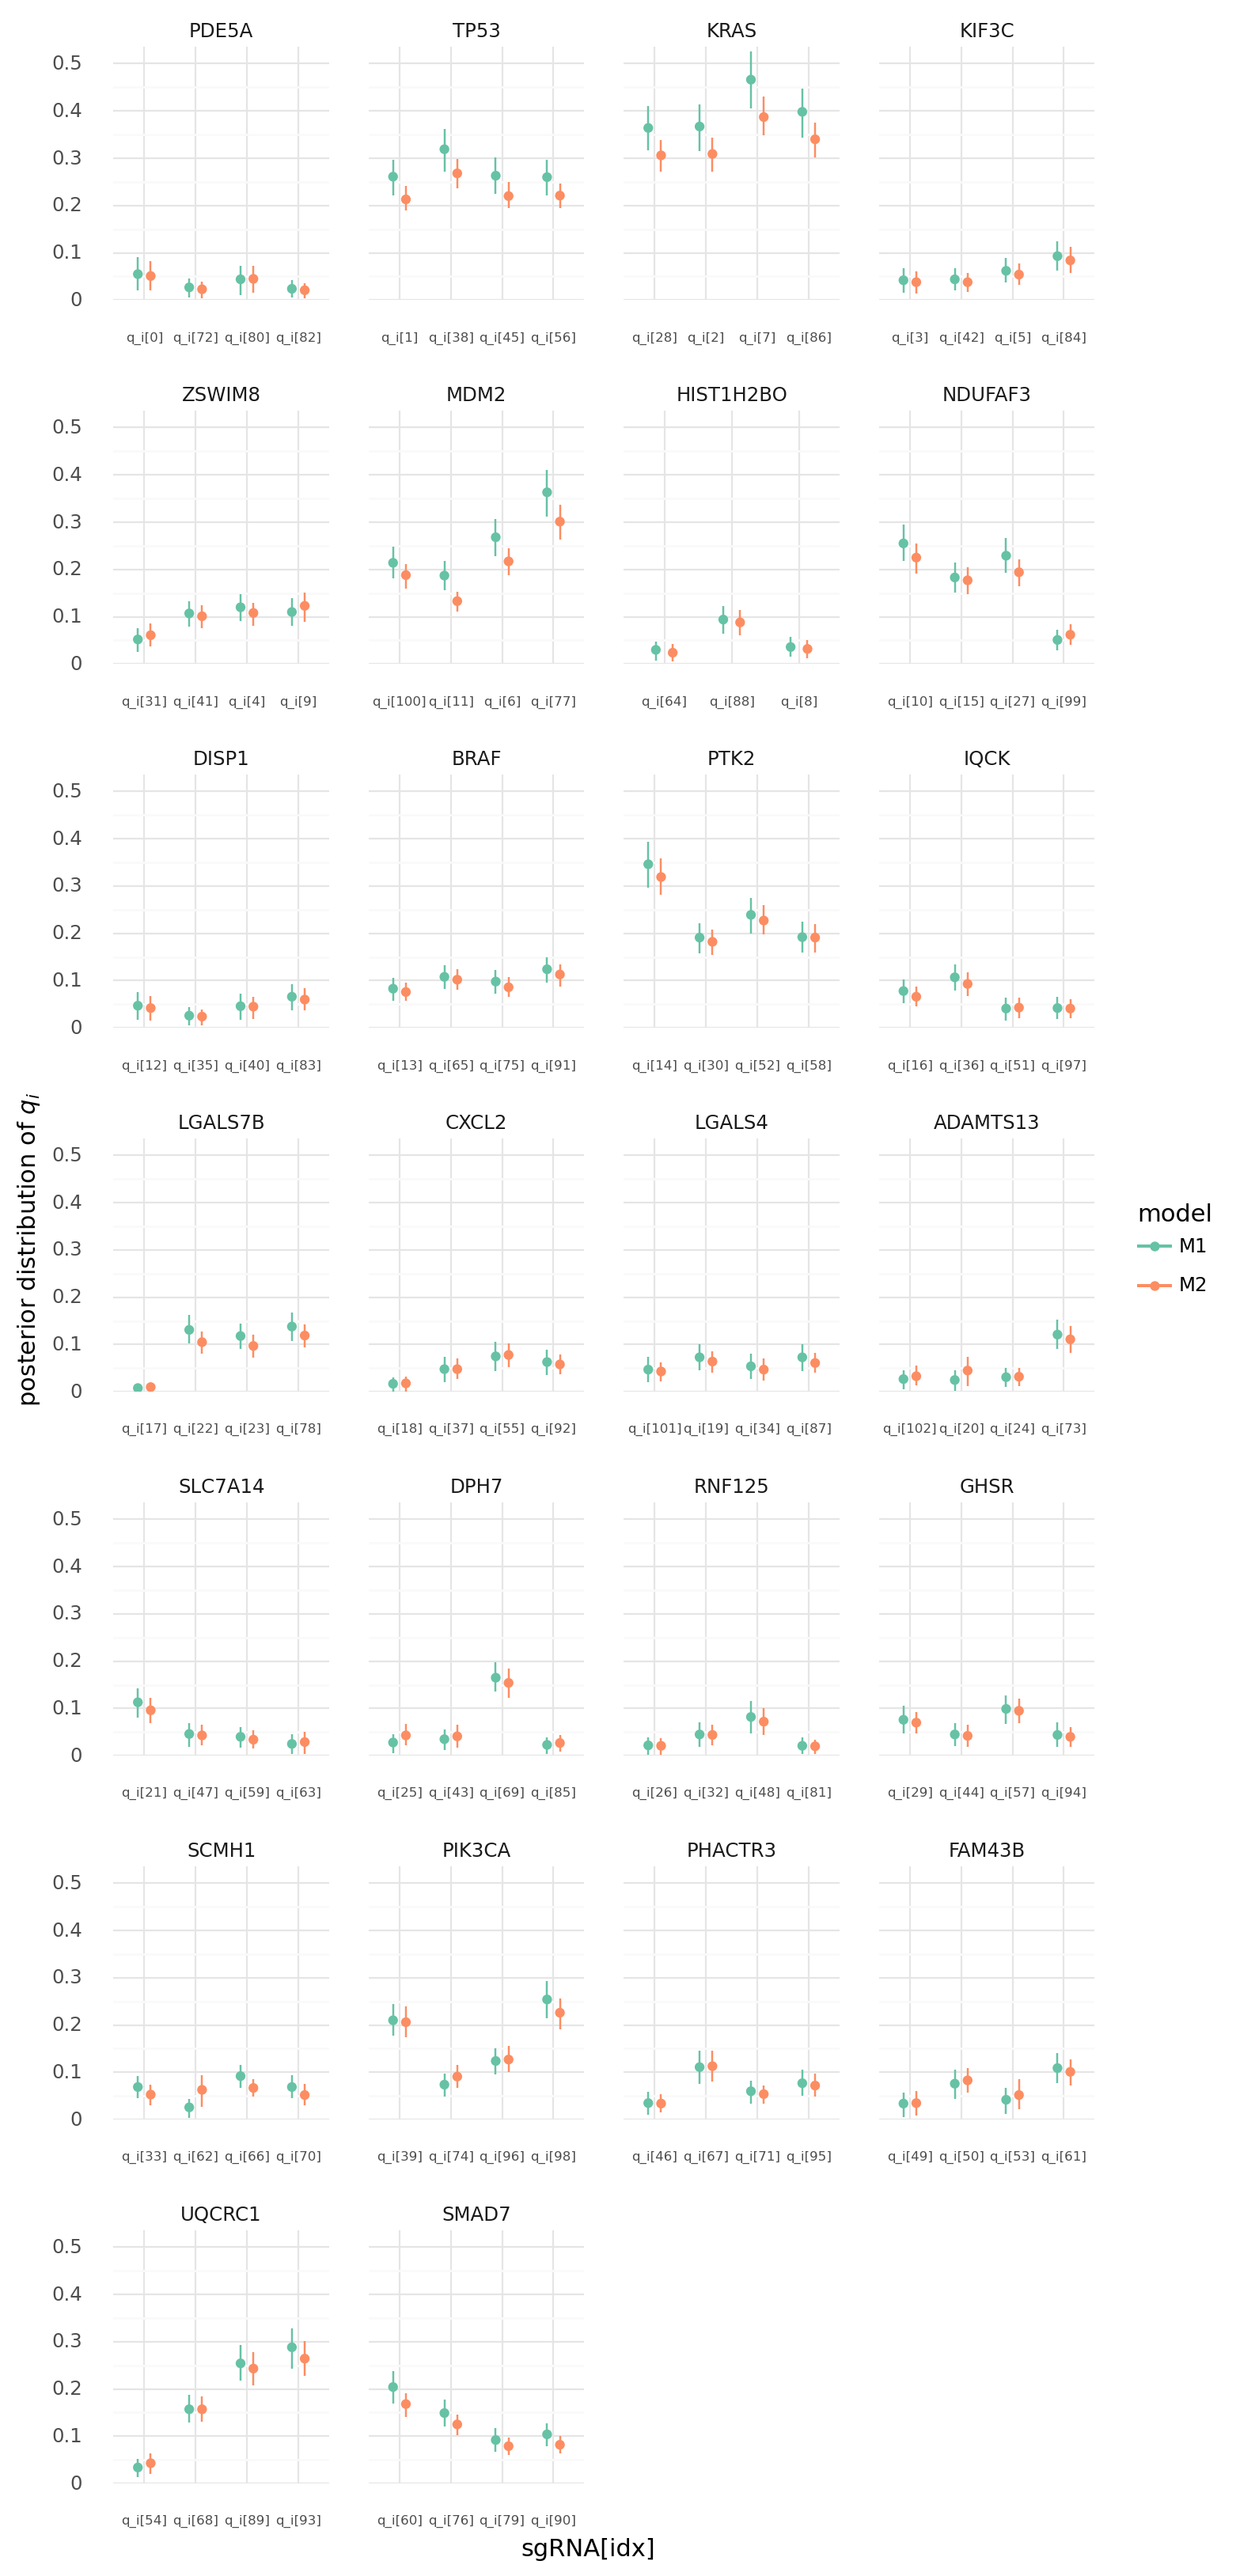

<ggplot: (8768008337815)>

In [42]:
pos = gg.position_dodge(width=0.5)

(
    gg.ggplot(ceres_q1_post, gg.aes(x="variable", y="mean", color="ceres"))
    + gg.facet_wrap("hugo_symbol", scales="free_x", ncol=4)
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), position=pos)
    + gg.geom_point(position=pos)
    + gg.scale_color_brewer(type="qual", palette="Set2")
    + gg.scale_y_continuous(limits=(0, None), expand=(0, 0, 0.02, 0))
    + gg.theme(
        figure_size=(8, 20),
        panel_spacing_x=0.25,
        panel_spacing_y=0.5,
        axis_text_x=gg.element_text(size=6),
    )
    + gg.labs(x="sgRNA[idx]", y="posterior distribution of $q_i$", color="model")
)

In [43]:
def make_index_df(df, col, idx_col_name):
    return (
        df[[col]]
        .drop_duplicates()
        .assign(_idx=lambda d: d[col].cat.codes)
        .reset_index(drop=True)
        .rename(columns={"_idx": idx_col_name})
    )


gene_idx_df = make_index_df(data, "hugo_symbol", "gene_idx")
cell_line_idx_df = make_index_df(data, "depmap_id", "cell_line_idx")

ceres_g_kj_post = (
    ceres_merged_summary[ceres_merged_summary["variable"].str.contains("g_kj")]
    .reset_index(drop=True)
    .assign(
        indices=lambda d: [re.findall(r"\d+", x) for x in d.variable],
        gene_idx=lambda d: [int(x[0]) for x in d.indices],
        cell_line_idx=lambda d: [int(x[1]) for x in d.indices],
    )
    .merge(gene_idx_df, how="left", on="gene_idx")
    .merge(cell_line_idx_df, how="left", on="cell_line_idx")
)

ceres_g_kj_post.head()

variable   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
0  g_kj[0,0]  1.190  1.553    -1.244      3.685      0.016    0.014    9948.0   
1  g_kj[0,1]  1.265  1.632    -1.313      3.940      0.017    0.015    9094.0   
2  g_kj[0,2] -0.993  1.715    -3.641      1.832      0.020    0.016    7069.0   
3  g_kj[0,3] -1.046  1.738    -3.822      1.725      0.022    0.016    5967.0   
4  g_kj[0,4] -0.099  1.622    -2.664      2.553      0.020    0.016    6512.0   

   ess_sd  ess_bulk  ess_tail  r_hat ceres indices  gene_idx  cell_line_idx  \
0  6561.0   10021.0    5778.0    1.0    M1  [0, 0]         0              0   
1  6306.0    9108.0    6568.0    1.0    M1  [0, 1]         0              1   
2  5481.0    7065.0    6420.0    1.0    M1  [0, 2]         0              2   
3  5691.0    5984.0    5622.0    1.0    M1  [0, 3]         0              3   
4  4914.0    6518.0    6268.0    1.0    M1  [0, 4]         0              4   

  hugo_symbol   depmap_id  
0       PDE5A  ACH-000757  
1       PDE5A  ACH-001329  
2       PDE5A  ACH-000535  
3       PDE5A  ACH-001460  
4       PDE5A  ACH-000867

In [44]:
values = ["mean", "hdi_5.5%", "hdi_94.5%"]
ceres_g_kj_wide = None

for value in values:
    df = (
        ceres_g_kj_post.pivot(
            index=["variable", "gene_idx", "cell_line_idx", "hugo_symbol", "depmap_id"],
            columns="ceres",
            values=value,
        )
        .reset_index()
        .rename(columns={"M1": f"M1_{value}", "M2": f"M2_{value}"})
    )
    if ceres_g_kj_wide is None:
        ceres_g_kj_wide = df
    else:
        ceres_g_kj_wide = ceres_g_kj_wide.merge(df)


ceres_g_kj_wide = ceres_g_kj_wide.merge(
    data[["hugo_symbol", "depmap_id", "gene_cn"]], how="left"
).drop_duplicates()

ceres_g_kj_wide.head()

variable  gene_idx  cell_line_idx hugo_symbol   depmap_id  M1_mean  \
0    g_kj[0,0]         0              0       PDE5A  ACH-000757    1.190   
12  g_kj[0,10]         0             10       PDE5A  ACH-001054   -0.040   
24  g_kj[0,11]         0             11       PDE5A  ACH-000243   -0.326   
40  g_kj[0,12]         0             12       PDE5A  ACH-000706   -0.089   
48  g_kj[0,13]         0             13       PDE5A  ACH-000738   -0.294   

    M2_mean  M1_hdi_5.5%  M2_hdi_5.5%  M1_hdi_94.5%  M2_hdi_94.5%   gene_cn  
0     1.464       -1.244       -1.138         3.685         3.978  1.645961  
12    0.422       -2.641       -2.183         2.634         3.138  1.933830  
24   -0.520       -2.575       -2.744         1.960         2.003  1.151427  
40    0.051       -2.539       -2.603         2.673         2.427  1.961443  
48   -0.359       -3.070       -3.062         2.100         2.110  1.303132

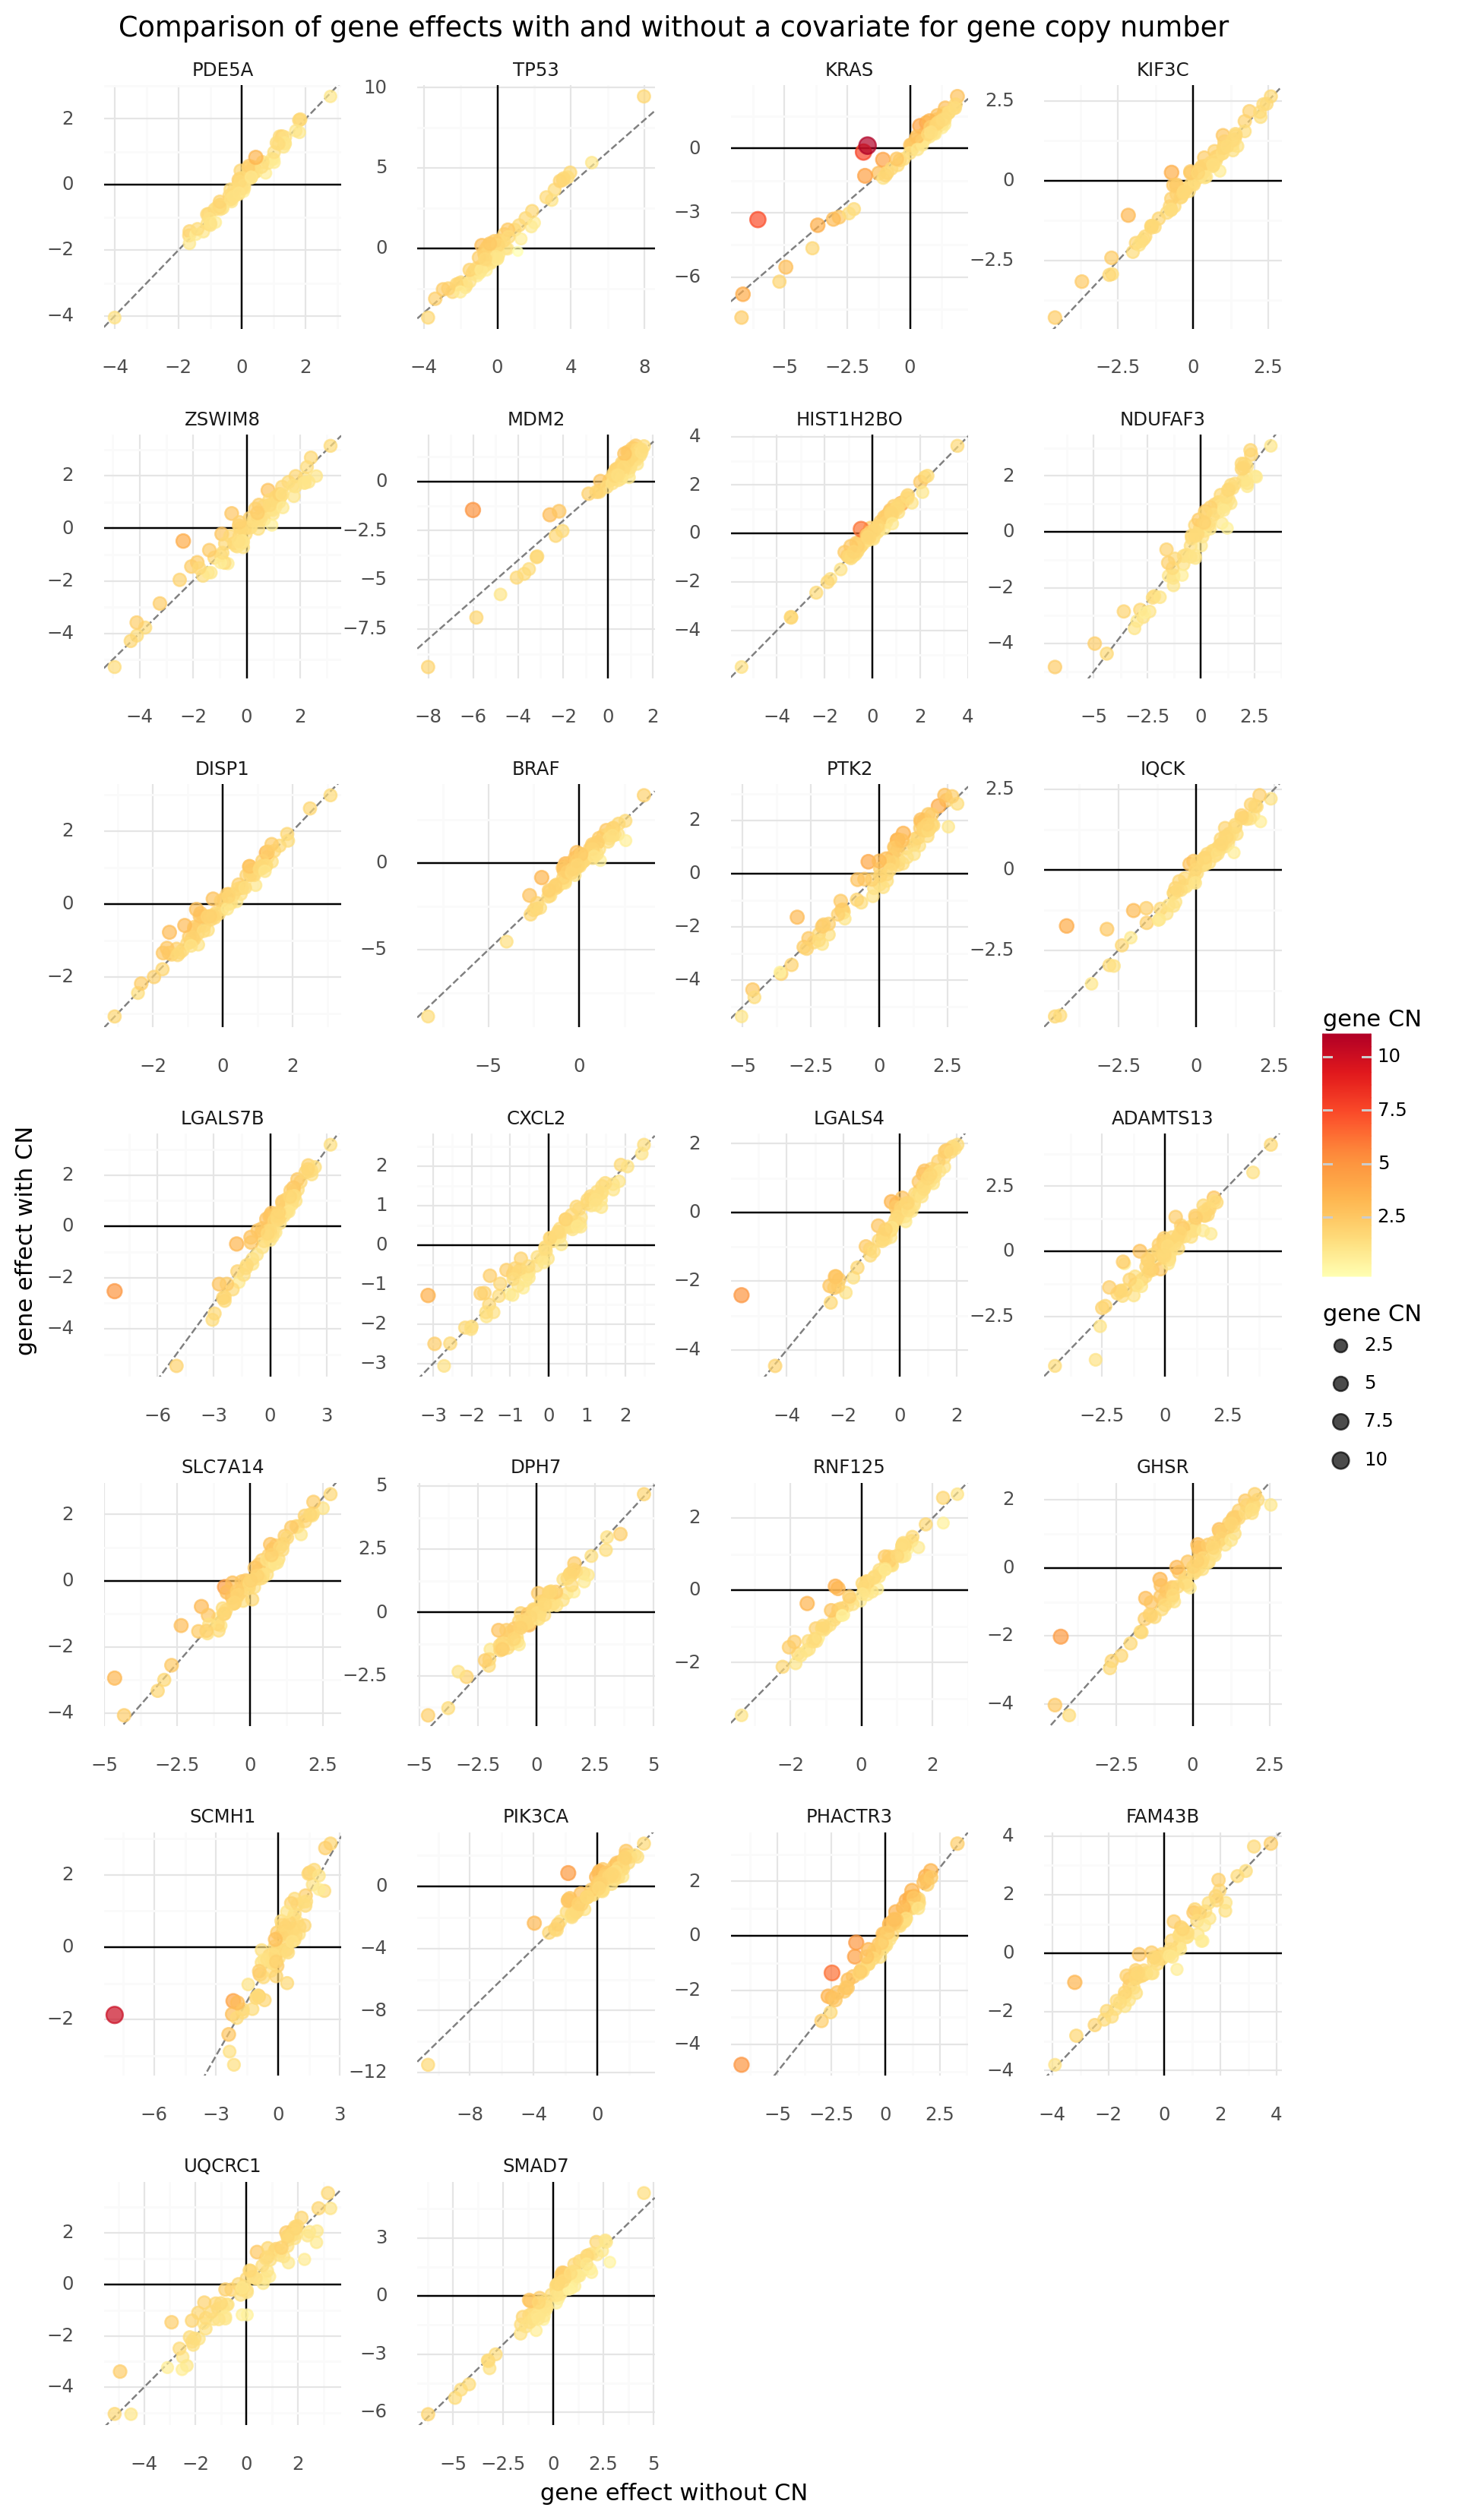

<ggplot: (8767734468819)>

In [45]:
(
    gg.ggplot(ceres_g_kj_wide, gg.aes(x="M1_mean", y="M2_mean"))
    + gg.facet_wrap("hugo_symbol", ncol=4, scales="free")
    + gg.geom_hline(yintercept=0, color="black")
    + gg.geom_vline(xintercept=0, color="black")
    + gg.geom_abline(slope=1, intercept=0, color="gray", linetype="--")
    + gg.geom_point(gg.aes(color="gene_cn", size="gene_cn"), alpha=0.7)
    + gg.scale_color_distiller(type="seq", palette="YlOrRd", direction=1)
    + gg.scale_size_continuous(range=(2, 4))
    + gg.theme(
        figure_size=(10, 20),
        panel_spacing_x=0.5,
        panel_spacing_y=0.5,
    )
    + gg.labs(
        x="gene effect without CN",
        y="gene effect with CN",
        color="gene CN",
        size="gene CN",
        title="Comparison of gene effects with and without a covariate for gene copy number",
    )
)

In [46]:
def summarize_ppc(az_m, var_name):
    x = az_m.posterior_predictive[var_name].values[0, :, :]
    x_mean = x.mean(axis=0)
    x_hdi = az.hdi(x, hdi_prob=0.89)
    return pd.DataFrame(
        {"mean": x_mean, "hdi_lower": x_hdi[:, 0], "hdi_upper": x_hdi[:, 1]}
    )

In [47]:
ceres_ppc_summary = []
for m, name in zip([az_ceres_m1, az_ceres_m2_advi], ["M1", "M2"]):
    df = summarize_ppc(az_ceres_m1, "D_ij").assign(
        ceres=name, idx=lambda d: list(range(len(d)))
    )
    df = pd.concat(
        [df, data[["lfc", "sgrna", "hugo_symbol", "depmap_id"]].reset_index(drop=True)],
        axis=1,
    )
    ceres_ppc_summary.append(df)

ceres_ppc_summary = pd.concat(ceres_ppc_summary).reset_index(drop=True)
ceres_ppc_summary.head(n=10)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


mean  hdi_lower  hdi_upper ceres  idx       lfc                 sgrna  \
0  0.324936  -0.226344   0.856244    M1    0  0.388453  AAGAGGCCGGTCAAATTCAG   
1  0.590178   0.044552   1.143577    M1    1  0.582574  AATCAACCCACAGCTGCACA   
2 -1.262714  -1.774204  -0.738222    M1    2 -1.464233  AATTACTACTTGCTTCCTGT   
3  0.010341  -0.549601   0.490825    M1    3  0.213791  ACCTGTATGACGAAACCGTG   
4 -0.049381  -0.558570   0.476010    M1    4  0.283606  ACTCTGTTCCTTCATCTCCG   
5  0.405142  -0.137215   0.910960    M1    5  0.506093  ACTGCTGCGGGAATTCCAAG   
6 -0.968127  -1.498412  -0.419038    M1    6 -0.714605  AGACACTTATACTATGAAAG   
7 -1.106449  -1.662529  -0.581180    M1    7 -1.388436  AGAGGAGTACAGTGCAATGA   
8  0.059115  -0.470620   0.563549    M1    8 -0.172670  AGATAGAGTAACTCTCTTTG   
9  0.040366  -0.482223   0.602149    M1    9  0.139808  AGTGCGGATGAGTTTCAGCG   

  hugo_symbol   depmap_id  
0       PDE5A  ACH-000757  
1        TP53  ACH-000757  
2        KRAS  ACH-000757  
3       KIF3C  ACH-000757  
4      ZSWIM8  ACH-000757  
5       KIF3C  ACH-000757  
6        MDM2  ACH-000757  
7        KRAS  ACH-000757  
8   HIST1H2BO  ACH-000757  
9      ZSWIM8  ACH-000757

In [48]:
def sample_ceres_ppc(az_m, n=200, label=None):
    ppc_sample = (
        pd.DataFrame(az_m.posterior_predictive["D_ij"].values[0, :, :])
        .sample(n=n)
        .reset_index(drop=True)
        .T
    )
    data_vars = ["depmap_id", "sgrna", "hugo_symbol"]
    df = pd.concat(
        [data[data_vars].copy().reset_index(drop=True), ppc_sample], axis=1
    ).melt(id_vars=data_vars, var_name="ppc_sample_idx", value_name="ppc_sample")

    if not label is None:
        df["label"] = label

    return df

In [49]:
ceres_ppc_df = pd.concat(
    [
        sample_ceres_ppc(az_ceres_m1, label="M1"),
        sample_ceres_ppc(az_ceres_m2_advi, label="M2"),
    ]
).reset_index(drop=True)
ceres_ppc_df.head()

depmap_id                 sgrna hugo_symbol ppc_sample_idx  ppc_sample  \
0  ACH-000757  AAGAGGCCGGTCAAATTCAG       PDE5A              0    0.070913   
1  ACH-000757  AATCAACCCACAGCTGCACA        TP53              0    0.894884   
2  ACH-000757  AATTACTACTTGCTTCCTGT        KRAS              0   -1.393183   
3  ACH-000757  ACCTGTATGACGAAACCGTG       KIF3C              0    0.142931   
4  ACH-000757  ACTCTGTTCCTTCATCTCCG      ZSWIM8              0    0.115612   

  label  
0    M1  
1    M1  
2    M1  
3    M1  
4    M1

---

### To-do

1. Update the Goal at the top indicating that the spline is unlikely to be viable.
2. Compare to the actual "gene effect" values reported by DepMap. This may require additional processing of the values in order to be comparable, so try to turn these into functions to be imported elsewhere, too.

---

In [50]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 10.63 minutes


In [51]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

plotnine 0.7.1
pandas   1.1.3
seaborn  0.11.0
re       2.2.1
numpy    1.19.2
pymc3    3.9.3
arviz    0.10.0
last updated: 2020-12-17 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 32
interpreter: 64bit
host name  : compute-a-16-78.o2.rc.hms.harvard.edu
Git branch : subset-data
